In [1]:
import numpy as np
import matplotlib.pyplot as plt
import muram as mio
from astropy.io import fits
import pyflct
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [2]:
import datashader.transfer_functions as tf
import datashader as ds
from datashader.mpl_ext import dsshow
import pandas as pd
import holoviews as hv
from holoviews.operation.datashader import dynspread
from holoviews.operation.datashader import datashade
import hvplot

In [3]:
from matplotlib import font_manager
import matplotlib as mpl
font_path = '/home/mistflow/.fonts/cmunrm.ttf'  # Your font path goes here
#font_path = '/usr/share/fonts/opentype/urw-base35/NimbusRoman-Italic.otf'
font_manager.fontManager.addfont(font_path)
prop = font_manager.FontProperties(fname=font_path)
mpl.rcParams["font.size"] = 14
mpl.rcParams['axes.formatter.useoffset'] = False
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = prop.get_name()
#plt.rc('text', usetex=True)
plt.rc('axes', unicode_minus=False)
width, height = plt.rcParams.get('figure.figsize')

In [4]:
from scipy.stats import pearsonr
from scipy.ndimage import gaussian_filter
from scipy.stats import linregress
import seaborn as sns

In [5]:
def temporal_avg(data_in, start, end):
    tmp_avg = np.mean(data_in[start:end+1], axis = 0)
    return tmp_avg

In [6]:
def mean_v_from_file(file):
    v_x = fits.open(file)[0].data.transpose(0, 2, 1)
    v_x.shape
    v_x = v_x[0:90]
    v_x = np.mean(v_x, axis=0)
    small = np.where(v_x < -6.5)
    v_x[small] = -6.5
    big = np.where(v_x > 6.5)
    v_x[big] = 6.5
    return v_x

def mean_vy_from_file(file):
    v_x = fits.open(file)[1].data.transpose(0, 2, 1)
    v_x.shape
    v_x = v_x[0:90]
    v_x = np.mean(v_x, axis=0)
    small = np.where(v_x < -6.5)
    v_x[small] = -6.5
    big = np.where(v_x > 6.5)
    v_x[big] = 6.5
    return v_x

In [7]:
def divv(Vx, Vy, stepsize):
    dvx_dx = np.gradient(Vx, axis=0)/stepsize
    dvy_dy = np.gradient(Vy, axis=1)/stepsize

    DIV = dvx_dx + dvy_dy
    return DIV

def rotorr(Vx, Vy, stepsize):
    dvx_dy = np.gradient(Vx, axis=1)/stepsize
    dvy_dx = np.gradient(Vy, axis=0)/stepsize

    ROTOR = dvy_dx - dvx_dy
    return (ROTOR)

<h2>19. 03. 2025.</h2>

In [8]:
cube_wfa = fits.open("loc_dyn_32_32_16_series_tumag_l2_wfa.fits")[0].data

In [9]:
np.shape(cube_wfa)

(31, 768, 768)

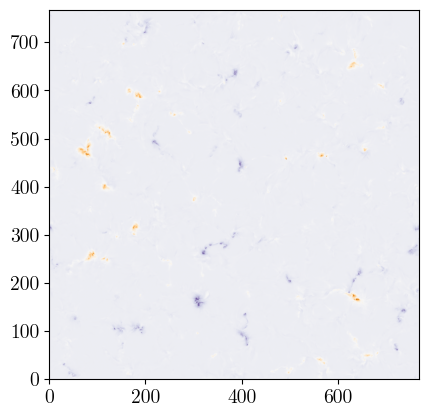

In [10]:
plt.imshow(cube_wfa[0,:,:].T, origin = "lower", cmap = "PuOr")

In [11]:
Bz_tm3 = fits.open("Bz_0_001.fits")[0].data
Bz_tm3 = Bz_tm3[::3, ::2, ::2]

In [12]:
Bz_tm4 = fits.open("Bz_0_0001.fits")[0].data
Bz_tm4 = Bz_tm4[::3, ::2, ::2]

In [13]:
Bz_tm4 = Bz_tm4.transpose(0, 2, 1)
Bz_tm3 = Bz_tm3.transpose(0, 2, 1)

In [14]:
Bz_tm1 = fits.open("Bz_0_100.fits")[0].data
Bz_tm1 = Bz_tm1[::3, ::2, ::2]
Bz_tm2 = fits.open("Bz_0_010.fits")[0].data
Bz_tm2 = Bz_tm2[::3, ::2, ::2]

In [15]:
Bz_tm1 = Bz_tm1.transpose(0, 2, 1)
Bz_tm2 = Bz_tm2.transpose(0, 2, 1)

In [16]:
R_m3_base = pearsonr(Bz_tm3[0].flatten(), cube_wfa[0].flatten())
print(R_m3_base)
R_m4_base = pearsonr(Bz_tm4[0].flatten(), cube_wfa[0].flatten())
print(R_m4_base)

PearsonRResult(statistic=np.float64(0.9141980441243527), pvalue=np.float64(0.0))
PearsonRResult(statistic=np.float64(0.8003005764408206), pvalue=np.float64(0.0))


In [17]:
Rm3 = pearsonr(np.mean(Bz_tm3, axis = 0), np.mean(cube_wfa, axis = 0))
#print(Rm3, end='\n')

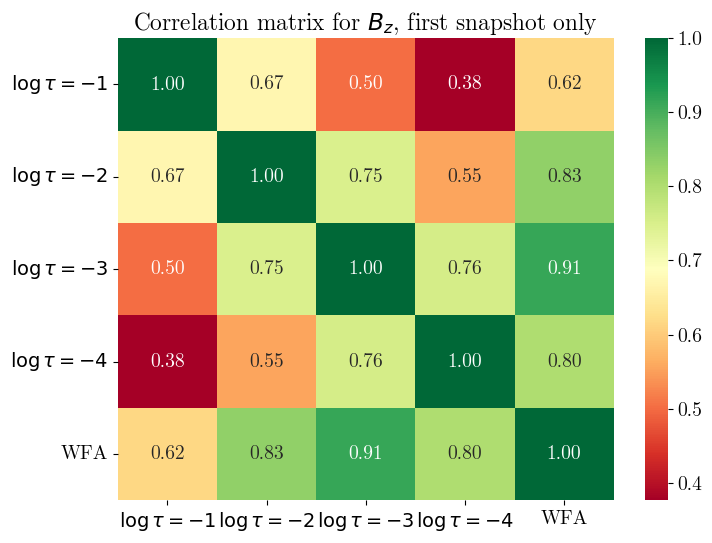

In [18]:
correlation_matrix = np.corrcoef([Bz_tm1[0,:,:].ravel(), Bz_tm2[0,:,:].ravel(),
                     Bz_tm3[0,:,:].ravel(), Bz_tm4[0,:,:].ravel(), 
                     cube_wfa[0,:,:].ravel()]) 

plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='RdYlGn',
            xticklabels=['$\log\\tau = -1$', '$\log\\tau = -2$', '$\log\\tau = -3$', '$\log\\tau = -4$', 'WFA'],
            yticklabels=['$\log\\tau = -1$', '$\log\\tau = -2$', '$\log\\tau = -3$', '$\log\\tau = -4$', 'WFA'])
plt.title('Correlation matrix for $B_z$, first snapshot only')
plt.savefig("WFA_vs_simBz.png", dpi = 70)
plt.show()

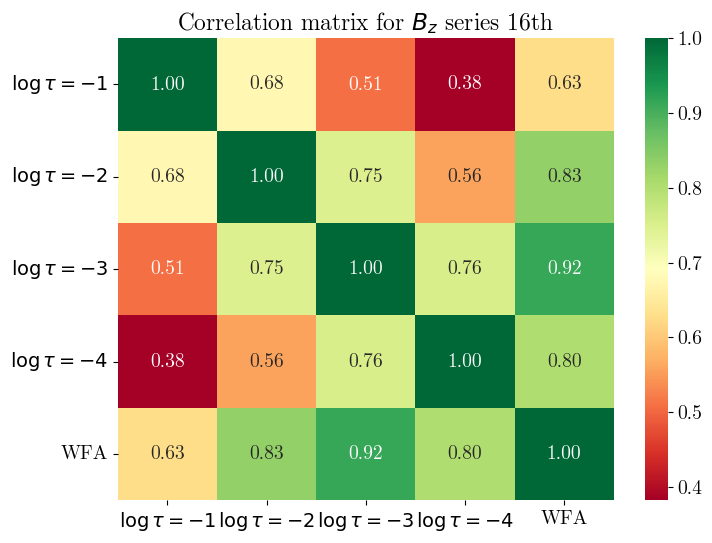

In [19]:
correlation_matrix = np.corrcoef([Bz_tm1[15,:,:].ravel(), Bz_tm2[15,:,:].ravel(),
                     Bz_tm3[15,:,:].ravel(), Bz_tm4[15,:,:].ravel(), 
                     cube_wfa[15,:,:].ravel()]) 

plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='RdYlGn',
            xticklabels=['$\log\\tau = -1$', '$\log\\tau = -2$', '$\log\\tau = -3$', '$\log\\tau = -4$', 'WFA'],
            yticklabels=['$\log\\tau = -1$', '$\log\\tau = -2$', '$\log\\tau = -3$', '$\log\\tau = -4$', 'WFA'])
plt.title('Correlation matrix for $B_z$ series 16th')
plt.savefig("allWFA_vs_simBz.png", dpi = 70)
plt.show()

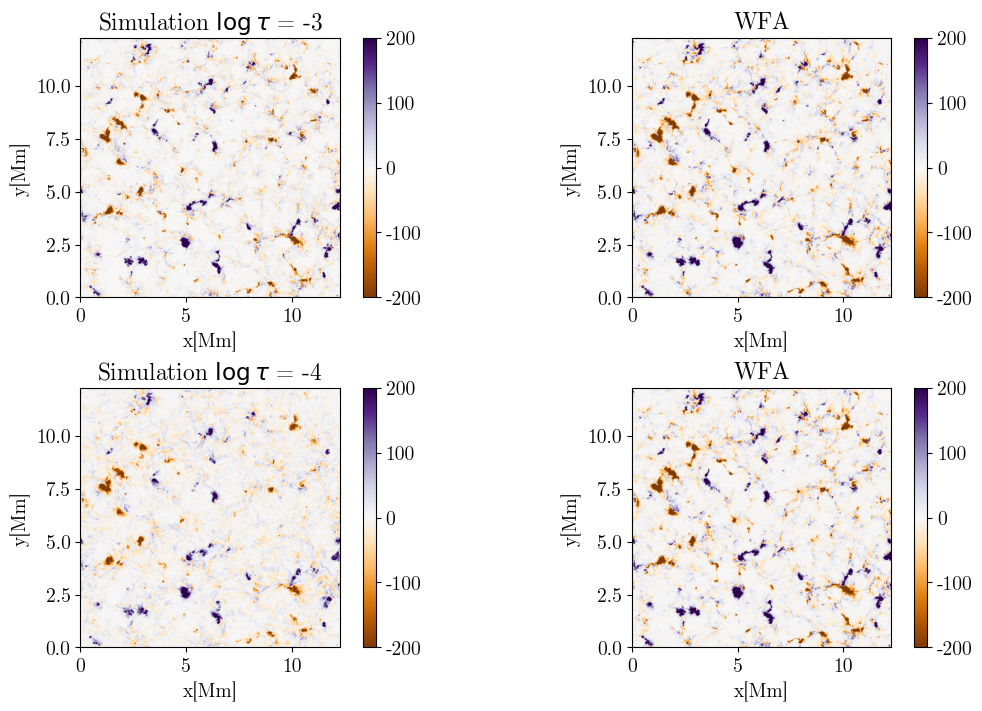

In [20]:
plt.figure(constrained_layout=True, figsize = (11,7))
#plt.suptitle("Linear fit of FLCT Vx and convolved Vx from simulation for FHWM = {1200, 600, 300, 100}km")
# 4x3 plot, velicina A, velicina B, scatter A i B!!!
ax1 = plt.subplot2grid((2,2), (0,0))
ax1.set_title("Simulation $\log\\tau$ = -3")
ax1.set_xlabel("x[Mm]")
ax1.set_ylabel("y[Mm]")
im1 = ax1.imshow(Bz_tm3[0, :, :].T, origin='lower', cmap = "PuOr", extent = (0, 12.268, 0, 12.268), vmin = -200, vmax = 200)
plt.colorbar(im1)


ax3 = plt.subplot2grid((2,2), (0,1))
ax3.set_title("WFA")
ax3.set_xlabel("x[Mm]")
ax3.set_ylabel("y[Mm]")
im3 = ax3.imshow(cube_wfa[0, :, :].T, origin='lower', cmap = "PuOr", extent = (0, 12.268, 0, 12.268), vmin = -200, vmax = 200)
plt.colorbar(im3)


ax4 = plt.subplot2grid((2,2), (1,0))
ax4.set_title("Simulation $\log\\tau$ = -4")
ax4.set_xlabel("x[Mm]")
ax4.set_ylabel("y[Mm]")
im4 = ax4.imshow(Bz_tm4[0, :, :].T, origin='lower', cmap = "PuOr", extent = (0, 12.268, 0, 12.268), vmin = -200, vmax = 200)
plt.colorbar(im4)


ax6 = plt.subplot2grid((2,2), (1,1))
ax6.set_title("WFA")
ax6.set_xlabel("x[Mm]")
ax6.set_ylabel("y[Mm]")
im6 = ax6.imshow(cube_wfa[0, :, :].T, origin='lower', cmap = "PuOr", extent = (0, 12.268, 0, 12.268), vmin = -200, vmax = 200)
plt.colorbar(im6)


#fig.tight_layout()
plt.savefig("Wfa_Bz.png", dpi = 70)

<h2>20. 03. 2025</h2>

<h3>Tracking comparison</h3>

In [21]:
Vx_ME_MgI = fits.open("pyFLCT_vx_vy_fwhm_600_dt_30_Bz_WFA_Mg_tracked.fits")[0].data
Vy_ME_MgI = fits.open("pyFLCT_vx_vy_fwhm_600_dt_30_Bz_WFA_Mg_tracked.fits")[1].data

In [22]:
np.shape(Vx_ME_MgI)

(30, 768, 768)

In [23]:
Vxm1 = fits.open("Velocities_TAU_0_1.fits")[1].data # Vy from Velocities.fits as originally thought
Vym1 = fits.open("Velocities_TAU_0_1.fits")[0].data # Vx from Velocities.fits as originally thought
Vxm1 = Vxm1[::3,::2,::2]/1E5
Vym1 = Vym1[::3,::2,::2]/1E5
#Vxm1 = Vxm1.transpose(0, 2, 1)
#Vym1 = Vym1.transpose(0, 2, 1)

In [24]:
Vxm2 = fits.open("Velocities_TAU_0_010.fits")[1].data # Vy from Velocities.fits as originally thought
Vym2 = fits.open("Velocities_TAU_0_010.fits")[0].data # Vx from Velocities.fits as originally thought
Vxm2 = Vxm2[::3,::2,::2]/1E5
Vym2 = Vym2[::3,::2,::2]/1E5
#Vxm2 = Vxm2.transpose(0, 2, 1)
#Vym2 = Vym2.transpose(0, 2, 1)

In [25]:
Vx_Bz1 = fits.open("pyFLCT_vx_vy_fwhm_600_dt_30_logTaum1Bz_tracked.fits")[0].data.transpose(0, 2, 1)
Vy_Bz1 = fits.open("pyFLCT_vx_vy_fwhm_600_dt_30_logTaum1Bz_tracked.fits")[1].data.transpose(0, 2, 1)
Vx_Bz1 = Vx_Bz1[:30,::2,::2]
Vy_Bz1 = Vy_Bz1[:30,::2,::2]

In [26]:
Vx_Bz2 = fits.open("pyFLCT_vx_vy_fwhm_600_dt_30_logTaum2Bz_tracked.fits")[0].data.transpose(0, 2, 1)
Vy_Bz2 = fits.open("pyFLCT_vx_vy_fwhm_600_dt_30_logTaum2Bz_tracked.fits")[1].data.transpose(0, 2, 1)
Vx_Bz2 = Vx_Bz2[:30,::2,::2]
Vy_Bz2 = Vy_Bz2[:30,::2,::2]

In [27]:
Vxm1_mean = temporal_avg(Vxm1, 0, 90)
#Vxm1_mean = Vxm1_mean/1E5
Vym1_mean = temporal_avg(Vym1, 0, 90)
#Vym1_mean = Vym1_mean/1E5

In [28]:
Vxm1_filtered600 = gaussian_filter(Vxm1_mean, 22.5/2, mode = "wrap")
Vym1_filtered600 = gaussian_filter(Vym1_mean, 22.5/2, mode = "wrap")

In [29]:
Vxm2_mean = temporal_avg(Vxm2, 0, 90)
#Vxm2_mean = Vxm2_mean/1E5
Vym2_mean = temporal_avg(Vym2, 0, 90)
#Vym2_mean = Vym2_mean/1E5

In [30]:
Vxm2_filtered600 = gaussian_filter(Vxm2_mean, 22.5/2, mode = "wrap")
Vym2_filtered600 = gaussian_filter(Vym2_mean, 22.5/2, mode = "wrap")

In [31]:
Vx_BzMg_mean = temporal_avg(Vx_ME_MgI, 0, 90)
Vy_BzMg_mean = temporal_avg(Vy_ME_MgI, 0, 90)

In [32]:
Vx_Bz1_cor = mean_v_from_file("pyFLCT_vx_vy_fwhm_600_dt_30_logTaum1Bz_tracked.fits")
Vy_Bz1_cor = mean_vy_from_file("pyFLCT_vx_vy_fwhm_600_dt_30_logTaum1Bz_tracked.fits")

In [33]:
Vx_Bz2_cor = mean_v_from_file("pyFLCT_vx_vy_fwhm_600_dt_30_logTaum2Bz_tracked.fits")
Vy_Bz2_cor = mean_vy_from_file("pyFLCT_vx_vy_fwhm_600_dt_30_logTaum2Bz_tracked.fits")

In [34]:
Vx_BzMgI_cor = mean_v_from_file("pyFLCT_vx_vy_fwhm_600_dt_30_Bz_WFA_Mg_tracked.fits")
Vy_BzMgI_cor = mean_vy_from_file("pyFLCT_vx_vy_fwhm_600_dt_30_Bz_WFA_Mg_tracked.fits")

In [35]:
Vx_Bz1_mean = temporal_avg(Vx_Bz1, 0, 90)
Vy_Bz1_mean = temporal_avg(Vy_Bz1, 0, 90)
#Vx_Bz1_mean = Vx_Bz1_mean[::2,::2]
#Vy_Bz1_mean = Vy_Bz1_mean[::2,::2]

In [36]:
Vx_Bz2_mean = temporal_avg(Vx_Bz2, 0, 90)
Vy_Bz2_mean = temporal_avg(Vy_Bz2, 0, 90)
#Vx_Bz2_mean = Vx_Bz2_mean[::2,::2]
#Vy_Bz2_mean = Vy_Bz2_mean[::2,::2]

In [37]:
Vx_Bz2_cor = Vx_Bz2_cor[::2,::2]
Vy_Bz2_cor = Vy_Bz2_cor[::2,::2]

#Vx_Bz2_cor = Vx_Bz2_cor.reshape(768, 2, 768, 2)
#Vx_Bz2_cor = Vx_Bz2_cor.mean(axis = 3).mean(axis = 1)

#Vy_Bz2_cor = Vy_Bz2_cor.reshape(768, 2, 768, 2)
#Vy_Bz2_cor = Vy_Bz2_cor.mean(axis = 3).mean(axis = 1)

In [38]:
Vx_Bz1_cor = Vx_Bz1_cor[::2,::2]
Vy_Bz1_cor = Vy_Bz1_cor[::2,::2]

#Vx_Bz1_cor = Vx_Bz1_cor.reshape(768, 2, 768, 2)
#Vx_Bz1_cor = Vx_Bz1_cor.mean(axis = 3).mean(axis = 1)

#Vy_Bz1_cor = Vy_Bz1_cor.reshape(768, 2, 768, 2)
#Vy_Bz1_cor = Vy_Bz1_cor.mean(axis = 3).mean(axis = 1)

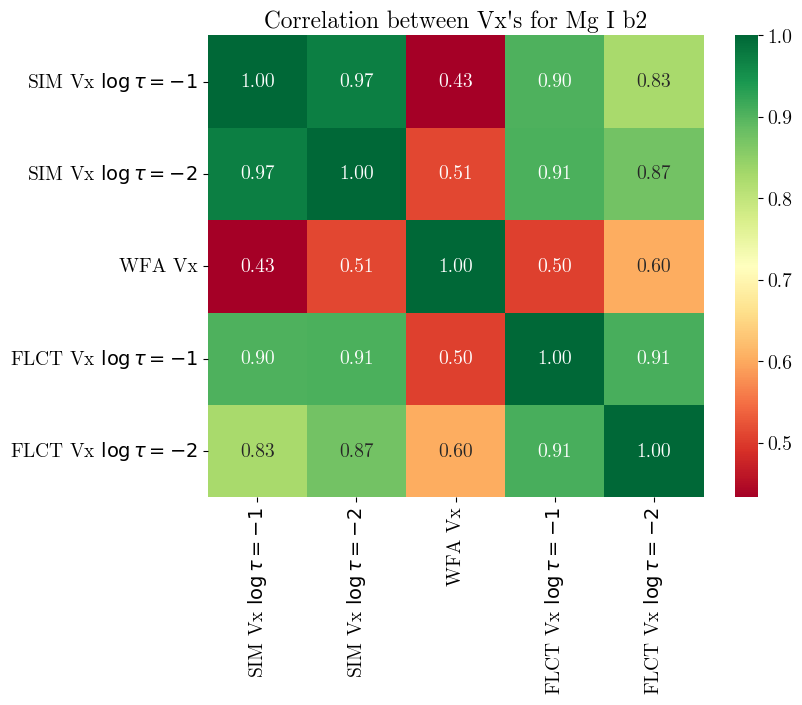

In [39]:
correlation_matrix = np.corrcoef([Vxm1_filtered600[:,:].ravel(), Vxm2_filtered600[:,:].ravel(),
                     Vx_BzMgI_cor[:,:].ravel(), Vx_Bz1_cor[:,:].ravel(), 
                     Vx_Bz2_cor[:,:].ravel()]) 

fig = plt.figure(figsize = (8,6))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='RdYlGn',
            xticklabels=['SIM Vx $\log\\tau = -1$', 'SIM Vx $\log\\tau = -2$', 'WFA Vx', 'FLCT Vx $\log\\tau = -1$', 'FLCT Vx $\log\\tau = -2$'],
            yticklabels=['SIM Vx $\log\\tau = -1$', 'SIM Vx $\log\\tau = -2$', 'WFA Vx', 'FLCT Vx $\log\\tau = -1$', 'FLCT Vx $\log\\tau = -2$'])
plt.title("Correlation between Vx\'s for Mg I b2")
plt.savefig("Averaged_cor_velb2.png", dpi = 70)
plt.show()

Text(0.5, 1.0, "Correlation between Vx's, corrected")

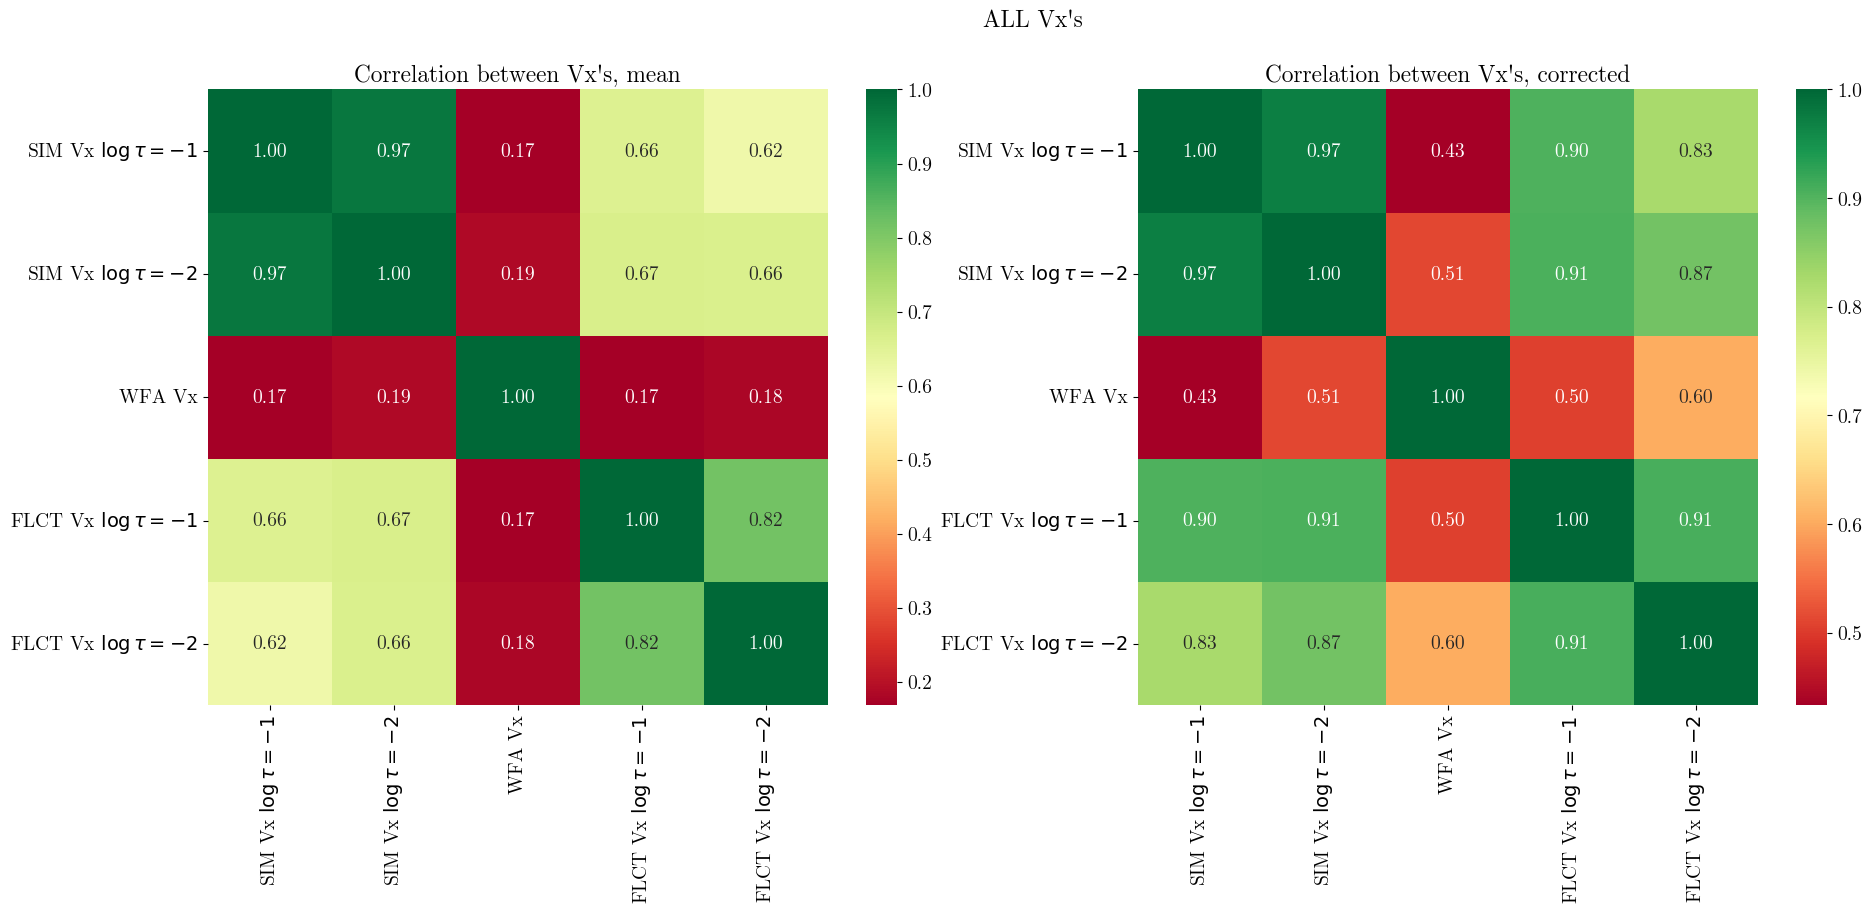

In [40]:
correlation_matrix = np.corrcoef([Vxm1_filtered600[:,:].ravel(), Vxm2_filtered600[:,:].ravel(),
                     Vx_BzMg_mean[:,:].ravel(), Vx_Bz1_mean[:,:].ravel(), 
                     Vx_Bz2_mean[:,:].ravel()])
fig = plt.figure(figsize = (22,8))
fig.suptitle("ALL Vx\'s")
ax1 = fig.add_subplot(121)
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='RdYlGn',
            xticklabels=['SIM Vx $\log\\tau = -1$', 'SIM Vx $\log\\tau = -2$', 'WFA Vx', 'FLCT Vx $\log\\tau = -1$', 'FLCT Vx $\log\\tau = -2$'],
            yticklabels=['SIM Vx $\log\\tau = -1$', 'SIM Vx $\log\\tau = -2$', 'WFA Vx', 'FLCT Vx $\log\\tau = -1$', 'FLCT Vx $\log\\tau = -2$'])
plt.title("Correlation between Vx\'s, mean")

correlation_matrix = np.corrcoef([Vxm1_filtered600[:,:].ravel(), Vxm2_filtered600[:,:].ravel(),
                     Vx_BzMgI_cor[:,:].ravel(), Vx_Bz1_cor[:,:].ravel(), 
                     Vx_Bz2_cor[:,:].ravel()])

ax2 = fig.add_subplot(122)
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='RdYlGn',
            xticklabels=['SIM Vx $\log\\tau = -1$', 'SIM Vx $\log\\tau = -2$', 'WFA Vx', 'FLCT Vx $\log\\tau = -1$', 'FLCT Vx $\log\\tau = -2$'],
            yticklabels=['SIM Vx $\log\\tau = -1$', 'SIM Vx $\log\\tau = -2$', 'WFA Vx', 'FLCT Vx $\log\\tau = -1$', 'FLCT Vx $\log\\tau = -2$'])
plt.title("Correlation between Vx\'s, corrected")
#plt.savefig("Correlatio_0_MgvsFe.png", dpi = 70)

Text(0.5, 1.0, "Correlation between Vy's, corrected")

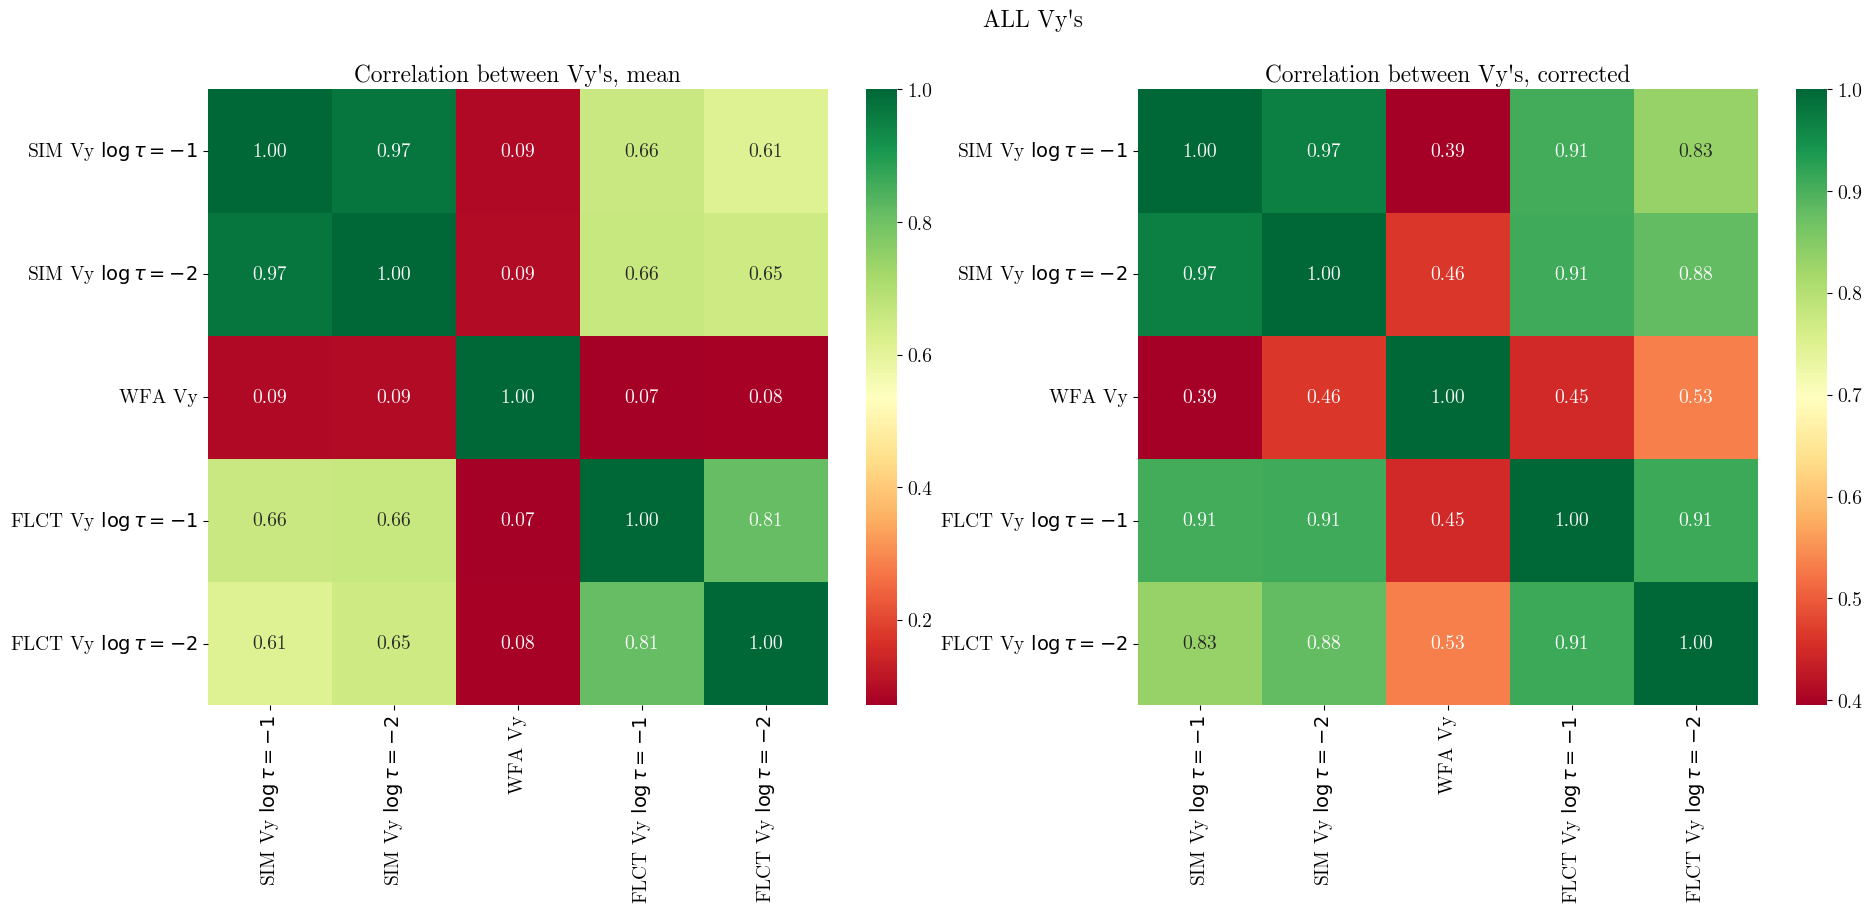

In [41]:
correlation_matrix = np.corrcoef([Vym1_filtered600[:,:].ravel(), Vym2_filtered600[:,:].ravel(),
                     Vy_BzMg_mean[:,:].ravel(), Vy_Bz1_mean[:,:].ravel(), 
                     Vy_Bz2_mean[:,:].ravel()])
fig = plt.figure(figsize = (22,8))
fig.suptitle("ALL Vy\'s")
ax1 = fig.add_subplot(121)
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='RdYlGn',
            xticklabels=['SIM Vy $\log\\tau = -1$', 'SIM Vy $\log\\tau = -2$', 'WFA Vy', 'FLCT Vy $\log\\tau = -1$', 'FLCT Vy $\log\\tau = -2$'],
            yticklabels=['SIM Vy $\log\\tau = -1$', 'SIM Vy $\log\\tau = -2$', 'WFA Vy', 'FLCT Vy $\log\\tau = -1$', 'FLCT Vy $\log\\tau = -2$'])
plt.title("Correlation between Vy\'s, mean")

correlation_matrix = np.corrcoef([Vym1_filtered600[:,:].ravel(), Vym2_filtered600[:,:].ravel(),
                     Vy_BzMgI_cor[:,:].ravel(), Vy_Bz1_cor[:,:].ravel(), 
                     Vy_Bz2_cor[:,:].ravel()])

ax2 = fig.add_subplot(122)
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='RdYlGn',
            xticklabels=['SIM Vy $\log\\tau = -1$', 'SIM Vy $\log\\tau = -2$', 'WFA Vy', 'FLCT Vy $\log\\tau = -1$', 'FLCT Vy $\log\\tau = -2$'],
            yticklabels=['SIM Vy $\log\\tau = -1$', 'SIM Vy $\log\\tau = -2$', 'WFA Vy', 'FLCT Vy $\log\\tau = -1$', 'FLCT Vy $\log\\tau = -2$'])
plt.title("Correlation between Vy\'s, corrected")
#plt.savefig("Correlatio_0_MgvsFe.png", dpi = 70)

<h4>FWHM = 300 km, $\log\tau = \{-1, -2\}$</h4>

In [42]:
Vx_ME3_MgI = fits.open("pyFLCT_vx_vy_fwhm_300_dt_30_Bz_WFA_Mg_tracked.fits")[0].data.transpose(0, 2, 1)
Vy_ME3_MgI = fits.open("pyFLCT_vx_vy_fwhm_300_dt_30_Bz_WFA_Mg_tracked.fits")[1].data.transpose(0, 2, 1)

In [43]:
Vxm1_filtered300 = gaussian_filter(Vxm1_mean, 11.25/2, mode = "wrap")
Vym1_filtered300 = gaussian_filter(Vym1_mean, 11.25/2, mode = "wrap")

In [44]:
Vxm2_filtered300 = gaussian_filter(Vxm2_mean, 11.25/2, mode = "wrap")
Vym2_filtered300 = gaussian_filter(Vym2_mean, 11.25/2, mode = "wrap")

In [45]:
Vx_Bz1_cor3 = mean_v_from_file("pyFLCT_vx_vy_fwhm_300_dt_30_logTaum1Bz_tracked.fits")
Vy_Bz1_cor3 = mean_vy_from_file("pyFLCT_vx_vy_fwhm_300_dt_30_logTaum1Bz_tracked.fits")

In [46]:
Vx_Bz2_cor3 = mean_v_from_file("pyFLCT_vx_vy_fwhm_300_dt_30_logTaum2Bz_tracked.fits")
Vy_Bz2_cor3 = mean_vy_from_file("pyFLCT_vx_vy_fwhm_300_dt_30_logTaum2Bz_tracked.fits")

In [47]:
Vx_BzMgI_cor3 = mean_v_from_file("pyFLCT_vx_vy_fwhm_300_dt_30_Bz_WFA_Mg_tracked.fits")
Vy_BzMgI_cor3 = mean_vy_from_file("pyFLCT_vx_vy_fwhm_300_dt_30_Bz_WFA_Mg_tracked.fits")

In [48]:
Vx_Bz2_cor3 = Vx_Bz2_cor3[::2,::2]
Vy_Bz2_cor3 = Vy_Bz2_cor3[::2,::2]

#Vx_Bz2_cor3 = Vx_Bz2_cor3.reshape(768, 2, 768, 2)
#Vx_Bz2_cor3 = Vx_Bz2_cor3.mean(axis = 3).mean(axis = 1)

#Vy_Bz2_cor3 = Vy_Bz2_cor3.reshape(768, 2, 768, 2)
#Vy_Bz2_cor3 = Vy_Bz2_cor3.mean(axis = 3).mean(axis = 1)

In [49]:
Vx_Bz1_cor3 = Vx_Bz1_cor3[::2,::2]
Vy_Bz1_cor3 = Vy_Bz1_cor3[::2,::2]

#Vx_Bz1_cor3 = Vx_Bz1_cor3.reshape(768, 2, 768, 2)
#Vx_Bz1_cor3 = Vx_Bz1_cor3.mean(axis = 3).mean(axis = 1)

#Vy_Bz1_cor3 = Vy_Bz1_cor3.reshape(768, 2, 768, 2)
#Vy_Bz1_cor3 = Vy_Bz1_cor3.mean(axis = 3).mean(axis = 1)

In [50]:
Vx_BzMgI3_mean = temporal_avg(Vx_ME3_MgI, 0, 90)
Vy_BzMgI3_mean = temporal_avg(Vy_ME3_MgI, 0, 90)

Text(0.5, 1.0, "Correlation between Vx's, corrected")

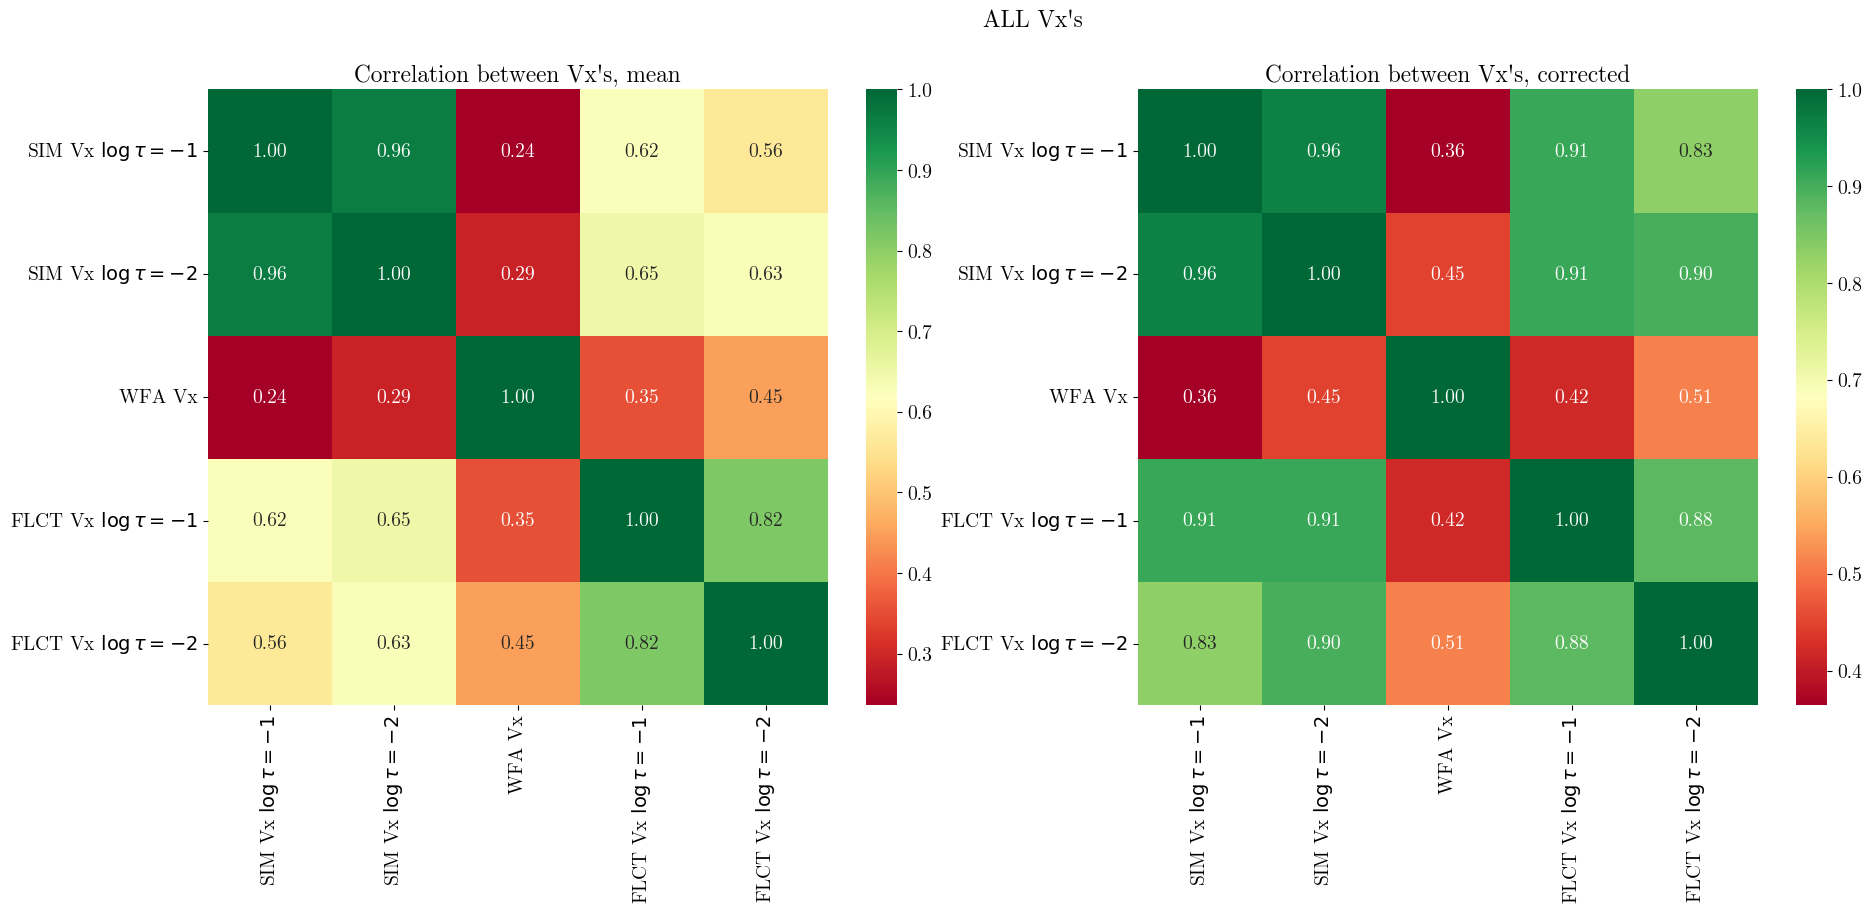

In [51]:
correlation_matrix = np.corrcoef([Vxm1_filtered300[:,:].ravel(), Vxm2_filtered300[:,:].ravel(),
                     Vx_BzMgI3_mean[:,:].ravel(), Vx_Bz1_mean[:,:].ravel(), 
                     Vx_Bz2_mean[:,:].ravel()])
fig = plt.figure(figsize = (22,8))
fig.suptitle("ALL Vx\'s")
ax1 = fig.add_subplot(121)
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='RdYlGn',
            xticklabels=['SIM Vx $\log\\tau = -1$', 'SIM Vx $\log\\tau = -2$', 'WFA Vx', 'FLCT Vx $\log\\tau = -1$', 'FLCT Vx $\log\\tau = -2$'],
            yticklabels=['SIM Vx $\log\\tau = -1$', 'SIM Vx $\log\\tau = -2$', 'WFA Vx', 'FLCT Vx $\log\\tau = -1$', 'FLCT Vx $\log\\tau = -2$'])
plt.title("Correlation between Vx\'s, mean")

correlation_matrix = np.corrcoef([Vxm1_filtered300[:,:].ravel(), Vxm2_filtered300[:,:].ravel(),
                     Vx_BzMgI_cor3[:,:].ravel(), Vx_Bz1_cor3[:,:].ravel(), 
                     Vx_Bz2_cor3[:,:].ravel()])

ax2 = fig.add_subplot(122)
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='RdYlGn',
            xticklabels=['SIM Vx $\log\\tau = -1$', 'SIM Vx $\log\\tau = -2$', 'WFA Vx', 'FLCT Vx $\log\\tau = -1$', 'FLCT Vx $\log\\tau = -2$'],
            yticklabels=['SIM Vx $\log\\tau = -1$', 'SIM Vx $\log\\tau = -2$', 'WFA Vx', 'FLCT Vx $\log\\tau = -1$', 'FLCT Vx $\log\\tau = -2$'])
plt.title("Correlation between Vx\'s, corrected")
#plt.savefig("Correlatio_0_MgvsFe.png", dpi = 70)

Text(0.5, 1.0, "Correlation between Vy's, corrected")

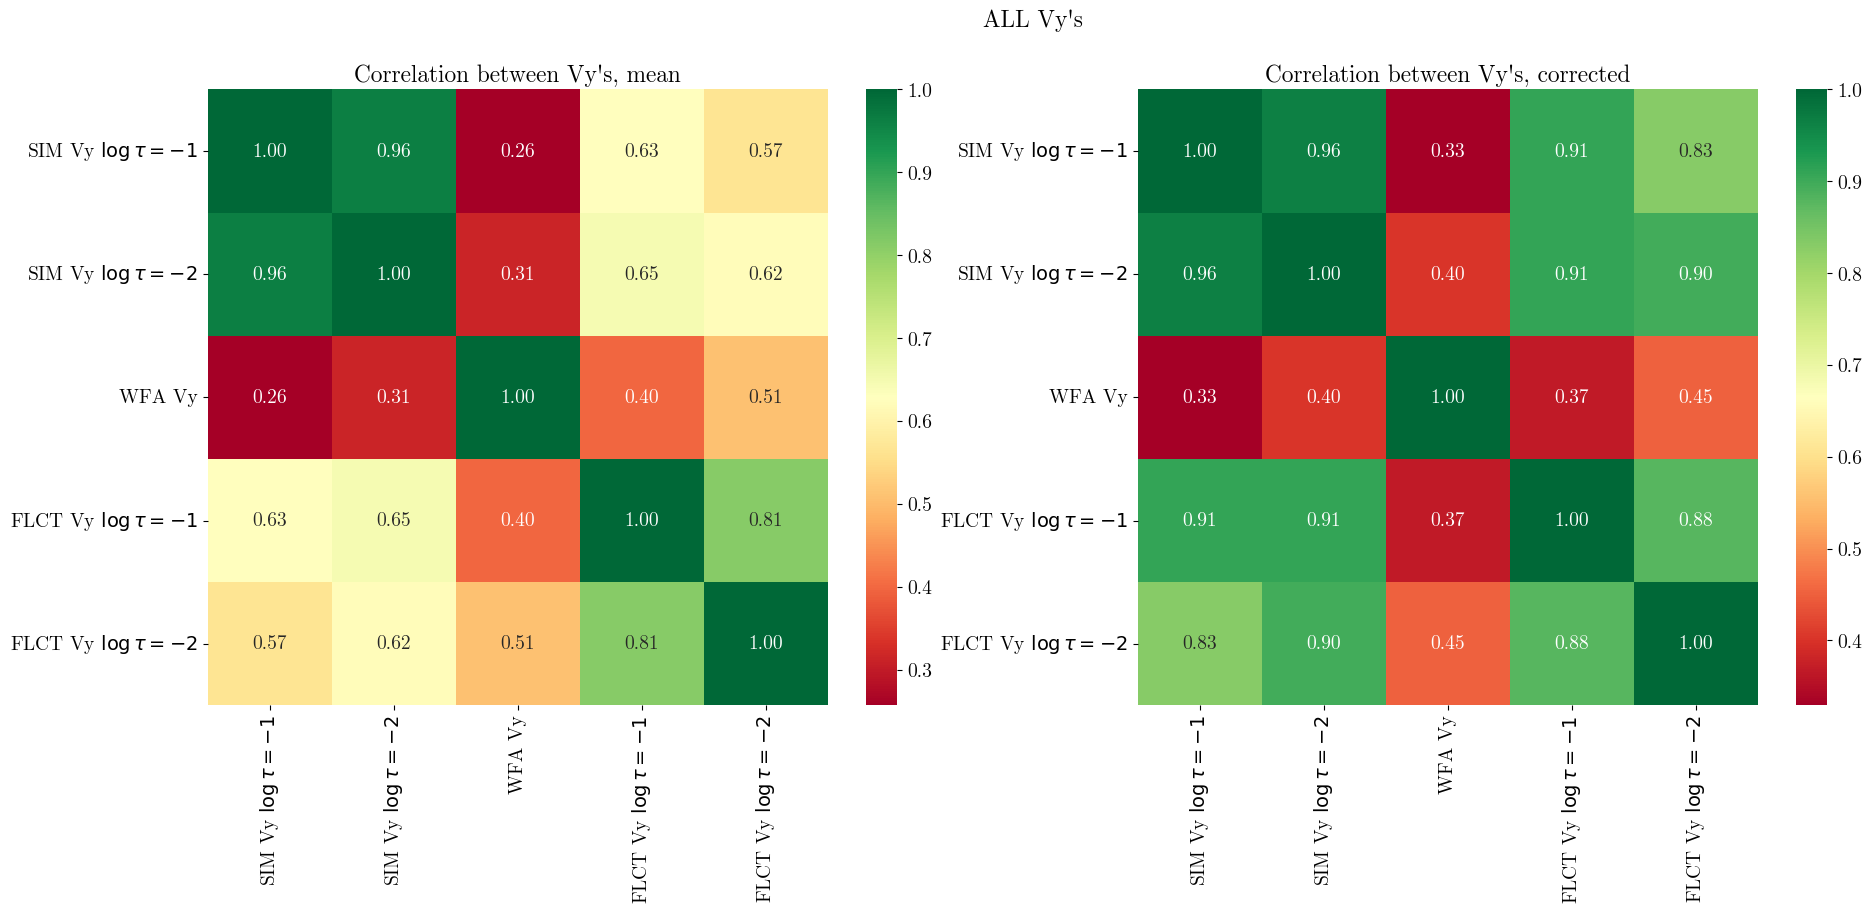

In [52]:
correlation_matrix = np.corrcoef([Vym1_filtered300[:,:].ravel(), Vym2_filtered300[:,:].ravel(),
                     Vy_BzMgI3_mean[:,:].ravel(), Vy_Bz1_mean[:,:].ravel(), 
                     Vy_Bz2_mean[:,:].ravel()])
fig = plt.figure(figsize = (22,8))
fig.suptitle("ALL Vy\'s")
ax1 = fig.add_subplot(121)
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='RdYlGn',
            xticklabels=['SIM Vy $\log\\tau = -1$', 'SIM Vy $\log\\tau = -2$', 'WFA Vy', 'FLCT Vy $\log\\tau = -1$', 'FLCT Vy $\log\\tau = -2$'],
            yticklabels=['SIM Vy $\log\\tau = -1$', 'SIM Vy $\log\\tau = -2$', 'WFA Vy', 'FLCT Vy $\log\\tau = -1$', 'FLCT Vy $\log\\tau = -2$'])
plt.title("Correlation between Vy\'s, mean")

correlation_matrix = np.corrcoef([Vym1_filtered300[:,:].ravel(), Vym2_filtered300[:,:].ravel(),
                     Vy_BzMgI_cor3[:,:].ravel(), Vy_Bz1_cor3[:,:].ravel(), 
                     Vy_Bz2_cor3[:,:].ravel()])

ax2 = fig.add_subplot(122)
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='RdYlGn',
            xticklabels=['SIM Vy $\log\\tau = -1$', 'SIM Vy $\log\\tau = -2$', 'WFA Vy', 'FLCT Vy $\log\\tau = -1$', 'FLCT Vy $\log\\tau = -2$'],
            yticklabels=['SIM Vy $\log\\tau = -1$', 'SIM Vy $\log\\tau = -2$', 'WFA Vy', 'FLCT Vy $\log\\tau = -1$', 'FLCT Vy $\log\\tau = -2$'])
plt.title("Correlation between Vy\'s, corrected")
#plt.savefig("Correlatio_0_MgvsFe.png", dpi = 70)

/tmp/ipykernel_32677/394883099.py:64: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.savefig("300_600_%2compMgI1.png", dpi = 75, bbox_inches = 'tight')
/home/mistflow/anaconda3/envs/FLCT/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


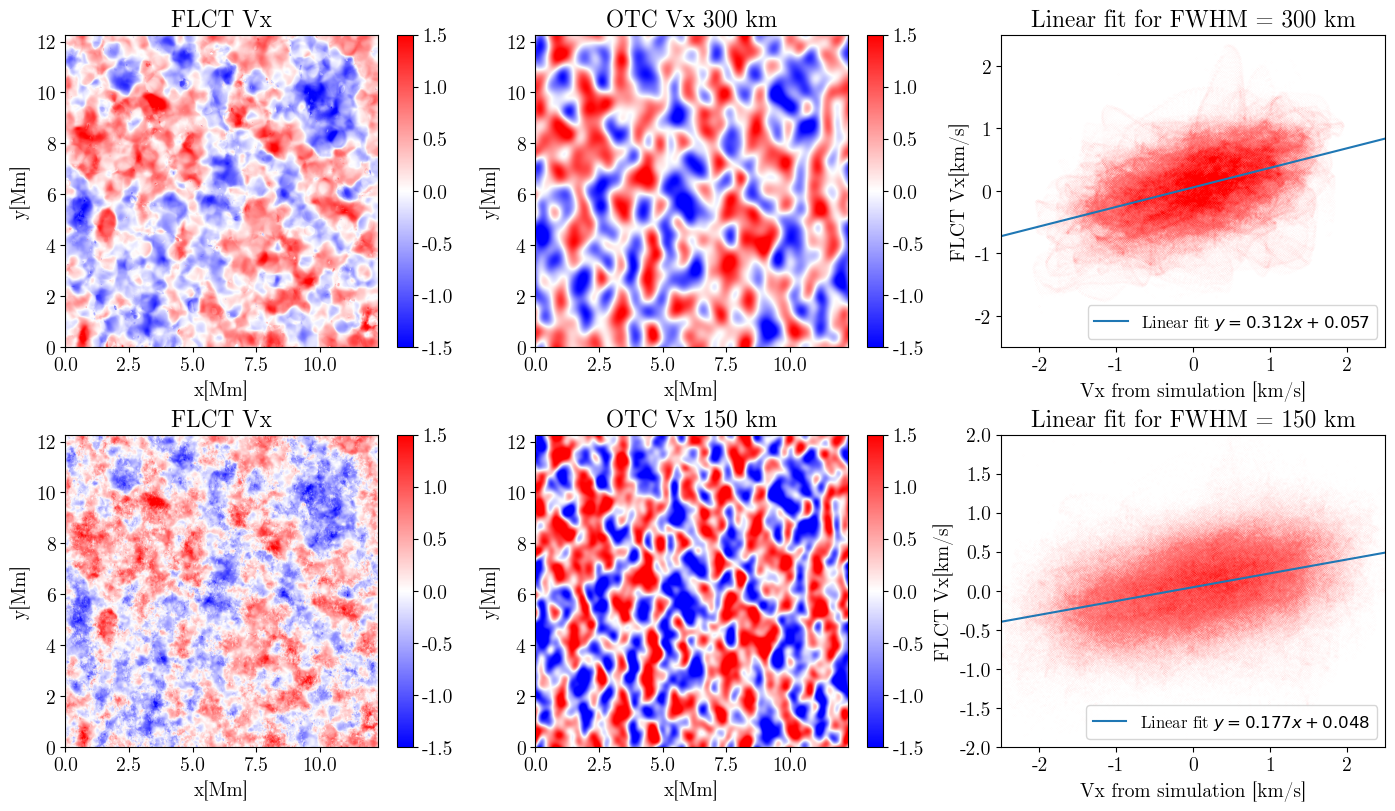

In [53]:
#fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(14, 8))
f = plt.figure(constrained_layout=True, figsize = (14,8))
#plt.suptitle("Linear fit of FLCT Vx and convolved Vx from simulation for FHWM = {1200, 600, 300, 100}km")
# 4x3 plot, velicina A, velicina B, scatter A i B!!!
#ax1 = plt.subplot2grid((4,3), (0,0))
ax1 = f.add_subplot(231)
ax1.set_title("FLCT Vx")
ax1.set_xlabel("x[Mm]")
ax1.set_ylabel("y[Mm]")
im1 = ax1.imshow(Vx_BzMgI_cor[:, :].T, origin='lower', cmap = "bwr", extent = (0, 12.268, 0, 12.268), vmin = -1.5, vmax = 1.5)
plt.colorbar(im1)

#ax2 = plt.subplot2grid((4,3), (0,1))
ax2 = f.add_subplot(232)
ax2.set_title("OTC Vx 300 km")
ax2.set_xlabel("x[Mm]")
ax2.set_ylabel("y[Mm]")
im2 = ax2.imshow(Vxm1_filtered600[:, :].T, origin='lower', cmap = "bwr", extent = (0, 12.268, 0, 12.268), vmin = -1.5, vmax = 1.5)
plt.colorbar(im2)

#ax3 = plt.subplot2grid((4,3), (0,2))
ax3 = f.add_subplot(233)
ax3.set_title("Linear fit for FWHM = 300 km")                                
ax3.set_ylabel("FLCT Vx[km/s]")
ax3.set_xlabel("Vx from simulation [km/s]")
ax3.scatter(Vxm1_filtered600.flatten(), Vx_BzMgI_cor.flatten(), s = 0.01, alpha = 0.05, color="red")
m1, b1, *_ = linregress(Vxm1_filtered600.flatten(), Vx_BzMgI_cor.flatten())
ax3.axline(xy1=(0, b1), slope=m1, label=f'Linear fit $y = {m1:.3f}x {b1:+.3f}$')
ax3.set_xlim(-2.5, 2.5)
ax3.set_ylim(-2.5, 2.5)
plt.legend(fontsize = 12)

#ax4 = plt.subplot2grid((4,3), (1,0))
ax4 = f.add_subplot(234)
ax4.set_title("FLCT Vx")
ax4.set_xlabel("x[Mm]")
ax4.set_ylabel("y[Mm]")
im4 = ax4.imshow(Vx_BzMgI_cor3[:, :].T, origin='lower', cmap = "bwr", extent = (0, 12.268, 0, 12.268), vmin = -1.5, vmax = 1.5)
plt.colorbar(im4)

#ax5 = plt.subplot2grid((4,3), (1,1))
ax5 = f.add_subplot(235)
ax5.set_title("OTC Vx 150 km")
ax5.set_xlabel("x[Mm]")
ax5.set_ylabel("y[Mm]")
im5 = ax5.imshow(Vxm1_filtered300[:, :].T, origin='lower', cmap = "bwr", extent = (0, 12.268, 0, 12.268), vmin = -1.5, vmax = 1.5)
plt.colorbar(im5)

#ax6 = plt.subplot2grid((4,3), (1,2))
ax6 = f.add_subplot(236)
ax6.set_title("Linear fit for FWHM = 150 km")                                
ax6.set_ylabel("FLCT Vx[km/s]")
ax6.set_xlabel("Vx from simulation [km/s]")
ax6.scatter(Vxm1_filtered300.flatten(), Vx_BzMgI_cor3.flatten(), s = 0.01, alpha = 0.05, color="red")
m2, b2, *_ = linregress(Vxm1_filtered300.flatten(), Vx_BzMgI_cor3.flatten())
ax6.axline(xy1=(0, b2), slope=m2, label=f'Linear fit $y = {m2:.3f}x {b2:+.3f}$')
ax6.set_xlim(-2.5, 2.5)
ax6.set_ylim(-2.0, 2.0)
plt.legend(fontsize = 12)



#plt.tight_layout()
plt.savefig("300_600_%2compMgI1.png", dpi = 75, bbox_inches = 'tight')

In [54]:
R = pearsonr(Vxm1_filtered600.flatten(), Vx_BzMgI_cor.flatten())
print(R)

PearsonRResult(statistic=np.float64(0.43316347861903576), pvalue=np.float64(0.0))


<h2 style="color:green; font-family:bold">Optical depths $\log\tau = \{-3, -4\}$</h2>

In [55]:
Vxm3 = fits.open("Velocities_TAU_0_001.fits")[1].data # Vy from Velocities.fits as originally thought
Vym3 = fits.open("Velocities_TAU_0_001.fits")[0].data # Vx from Velocities.fits as originally thought
Vxm3 = Vxm3[::3,::2,::2]/1E5
Vym3 = Vym3[::3,::2,::2]/1E5
#Vxm3 = Vxm3.transpose(0, 2, 1)
#Vym3 = Vym3.transpose(0, 2, 1)

In [56]:
Vxm4 = fits.open("Velocities_TAU_0_0001.fits")[1].data # Vy from Velocities.fits as originally thought
Vym4 = fits.open("Velocities_TAU_0_0001.fits")[0].data # Vx from Velocities.fits as originally thought
Vxm4 = Vxm4[::3,::2,::2]/1E5
Vym4 = Vym4[::3,::2,::2]/1E5
#Vxm4 = Vxm4.transpose(0, 2, 1)
#Vym4 = Vym4.transpose(0, 2, 1)

In [57]:
Vx_Bz3 = fits.open("pyFLCT_vx_vy_fwhm_600_dt_30_logTaum3Bz_tracked.fits")[0].data.transpose(0, 2, 1)
Vy_Bz3 = fits.open("pyFLCT_vx_vy_fwhm_600_dt_30_logTaum3Bz_tracked.fits")[1].data.transpose(0, 2, 1)
Vx_Bz3 = Vx_Bz3[:30,::2,::2]
Vy_Bz3 = Vy_Bz3[:30,::2,::2]

In [58]:
Vx_Bz4 = fits.open("pyFLCT_vx_vy_fwhm_600_dt_30_logTaum4Bz_tracked.fits")[0].data.transpose(0, 2, 1)
Vy_Bz4 = fits.open("pyFLCT_vx_vy_fwhm_600_dt_30_logTaum4Bz_tracked.fits")[1].data.transpose(0, 2, 1)
Vx_Bz4 = Vx_Bz4[:30,::2,::2]
Vy_Bz4 = Vy_Bz4[:30,::2,::2]

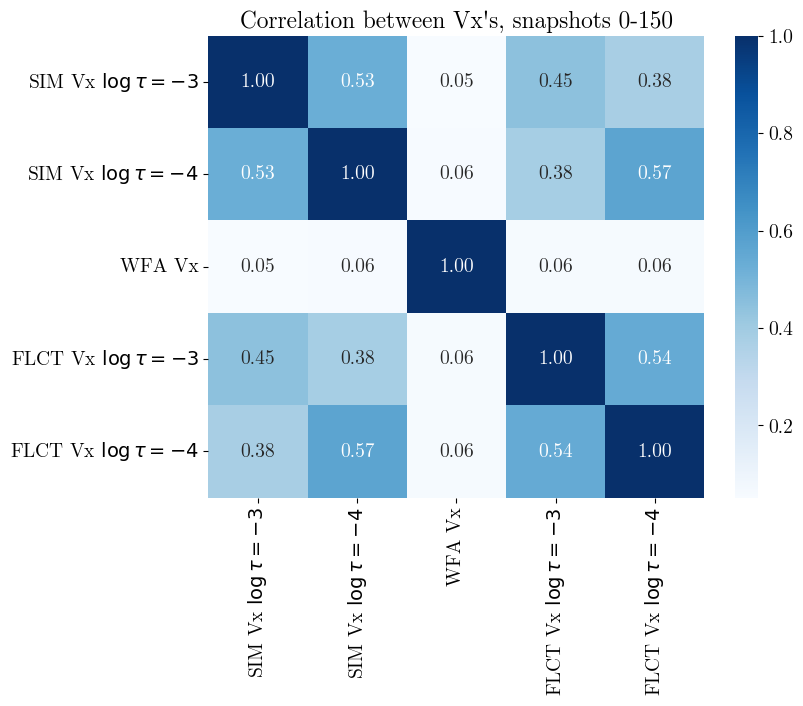

In [59]:
correlation_matrix = np.corrcoef([Vxm3[0,:,:].ravel(), Vxm4[0, :,:].ravel(),
                     Vx_ME_MgI[0,:,:].ravel(), Vx_Bz3[0,:,:].ravel(), 
                     Vx_Bz4[0,:,:].ravel()]) 

plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='Blues',
            xticklabels=['SIM Vx $\log\\tau = -3$', 'SIM Vx $\log\\tau = -4$', 'WFA Vx', 'FLCT Vx $\log\\tau = -3$', 'FLCT Vx $\log\\tau = -4$'],
            yticklabels=['SIM Vx $\log\\tau = -3$', 'SIM Vx $\log\\tau = -4$', 'WFA Vx', 'FLCT Vx $\log\\tau = -3$', 'FLCT Vx $\log\\tau = -4$'])
plt.title("Correlation between Vx\'s, snapshots 0-150")
plt.savefig("Vx_Mg_cor_rest.png", dpi = 70)
plt.show()

In [60]:
Vxm3_mean = temporal_avg(Vxm3, 0, 90)
#Vxm1_mean = Vxm1_mean/1E5
Vym3_mean = temporal_avg(Vym3, 0, 90)
#Vym1_mean = Vym1_mean/1E5

In [61]:
Vxm4_mean = temporal_avg(Vxm4, 0, 90)
#Vxm1_mean = Vxm1_mean/1E5
Vym4_mean = temporal_avg(Vym4, 0, 90)
#Vym1_mean = Vym1_mean/1E5

In [62]:
Vxm3_filtered600 = gaussian_filter(Vxm3_mean, 22.5/2, mode = "wrap")
Vym3_filtered600 = gaussian_filter(Vym3_mean, 22.5/2, mode = "wrap")

In [63]:
Vxm4_filtered600 = gaussian_filter(Vxm4_mean, 22.5/2, mode = "wrap")
Vym4_filtered600 = gaussian_filter(Vym4_mean, 22.5/2, mode = "wrap")

In [64]:
Vx_Bz3_cor = mean_v_from_file("pyFLCT_vx_vy_fwhm_600_dt_30_logTaum3Bz_tracked.fits")
Vy_Bz3_cor = mean_vy_from_file("pyFLCT_vx_vy_fwhm_600_dt_30_logTaum3Bz_tracked.fits")

In [65]:
Vx_Bz4_cor = mean_v_from_file("pyFLCT_vx_vy_fwhm_600_dt_30_logTaum4Bz_tracked.fits")
Vy_Bz4_cor = mean_vy_from_file("pyFLCT_vx_vy_fwhm_600_dt_30_logTaum4Bz_tracked.fits")

In [66]:
Vx_Bz3_cor = Vx_Bz3_cor[::2,::2]
Vy_Bz3_cor = Vy_Bz3_cor[::2,::2]

#Vx_Bz3_cor = Vx_Bz3_cor.reshape(768, 2, 768, 2)
#Vx_Bz3_cor = Vx_Bz3_cor.mean(axis = 3).mean(axis = 1)

#Vy_Bz3_cor = Vy_Bz3_cor.reshape(768, 2, 768, 2)
#Vy_Bz3_cor = Vy_Bz3_cor.mean(axis = 3).mean(axis = 1)

In [67]:
Vx_Bz4_cor = Vx_Bz4_cor[::2,::2]
Vy_Bz4_cor = Vy_Bz4_cor[::2,::2]

#Vx_Bz4_cor = Vx_Bz4_cor.reshape(768, 2, 768, 2)
#Vx_Bz4_cor = Vx_Bz4_cor.mean(axis = 3).mean(axis = 1)

#Vy_Bz4_cor = Vy_Bz4_cor.reshape(768, 2, 768, 2)
#Vy_Bz4_cor = Vy_Bz4_cor.mean(axis = 3).mean(axis = 1)

In [68]:
Vx_Bz3_mean = temporal_avg(Vx_Bz3, 0, 90)
Vy_Bz3_mean = temporal_avg(Vy_Bz3, 0, 90)
#Vx_Bz1_mean = Vx_Bz1_mean[::2,::2]
#Vy_Bz1_mean = Vy_Bz1_mean[::2,::2]

In [69]:
Vx_Bz4_mean = temporal_avg(Vx_Bz4, 0, 90)
Vy_Bz4_mean = temporal_avg(Vy_Bz4, 0, 90)
#Vx_Bz1_mean = Vx_Bz1_mean[::2,::2]
#Vy_Bz1_mean = Vy_Bz1_mean[::2,::2]

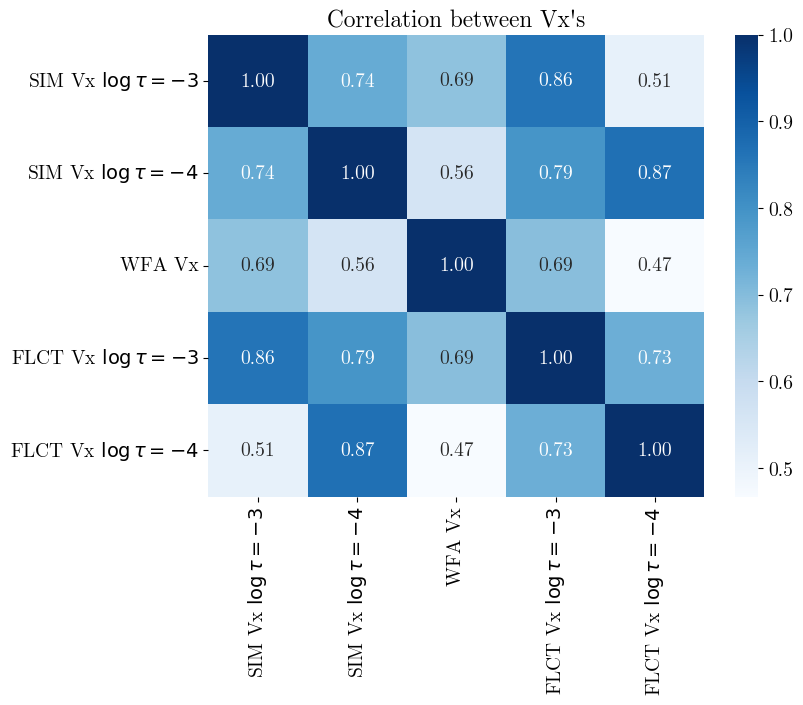

In [70]:
correlation_matrix = np.corrcoef([Vxm3_filtered600[:,:].ravel(), Vxm4_filtered600[:,:].ravel(),
                     Vx_BzMgI_cor[:,:].ravel(), Vx_Bz3_cor[:,:].ravel(), 
                     Vx_Bz4_cor[:,:].ravel()]) 

fig = plt.figure(figsize = (8,6))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='Blues',
            xticklabels=['SIM Vx $\log\\tau = -3$', 'SIM Vx $\log\\tau = -4$', 'WFA Vx', 'FLCT Vx $\log\\tau = -3$', 'FLCT Vx $\log\\tau = -4$'],
            yticklabels=['SIM Vx $\log\\tau = -3$', 'SIM Vx $\log\\tau = -4$', 'WFA Vx', 'FLCT Vx $\log\\tau = -3$', 'FLCT Vx $\log\\tau = -4$'])
plt.title("Correlation between Vx\'s")
plt.savefig("Mgrest_Averaged_cor_vel.png", dpi = 70)
plt.show()

Text(0.5, 1.0, "Correlation between Vx's, corrected")

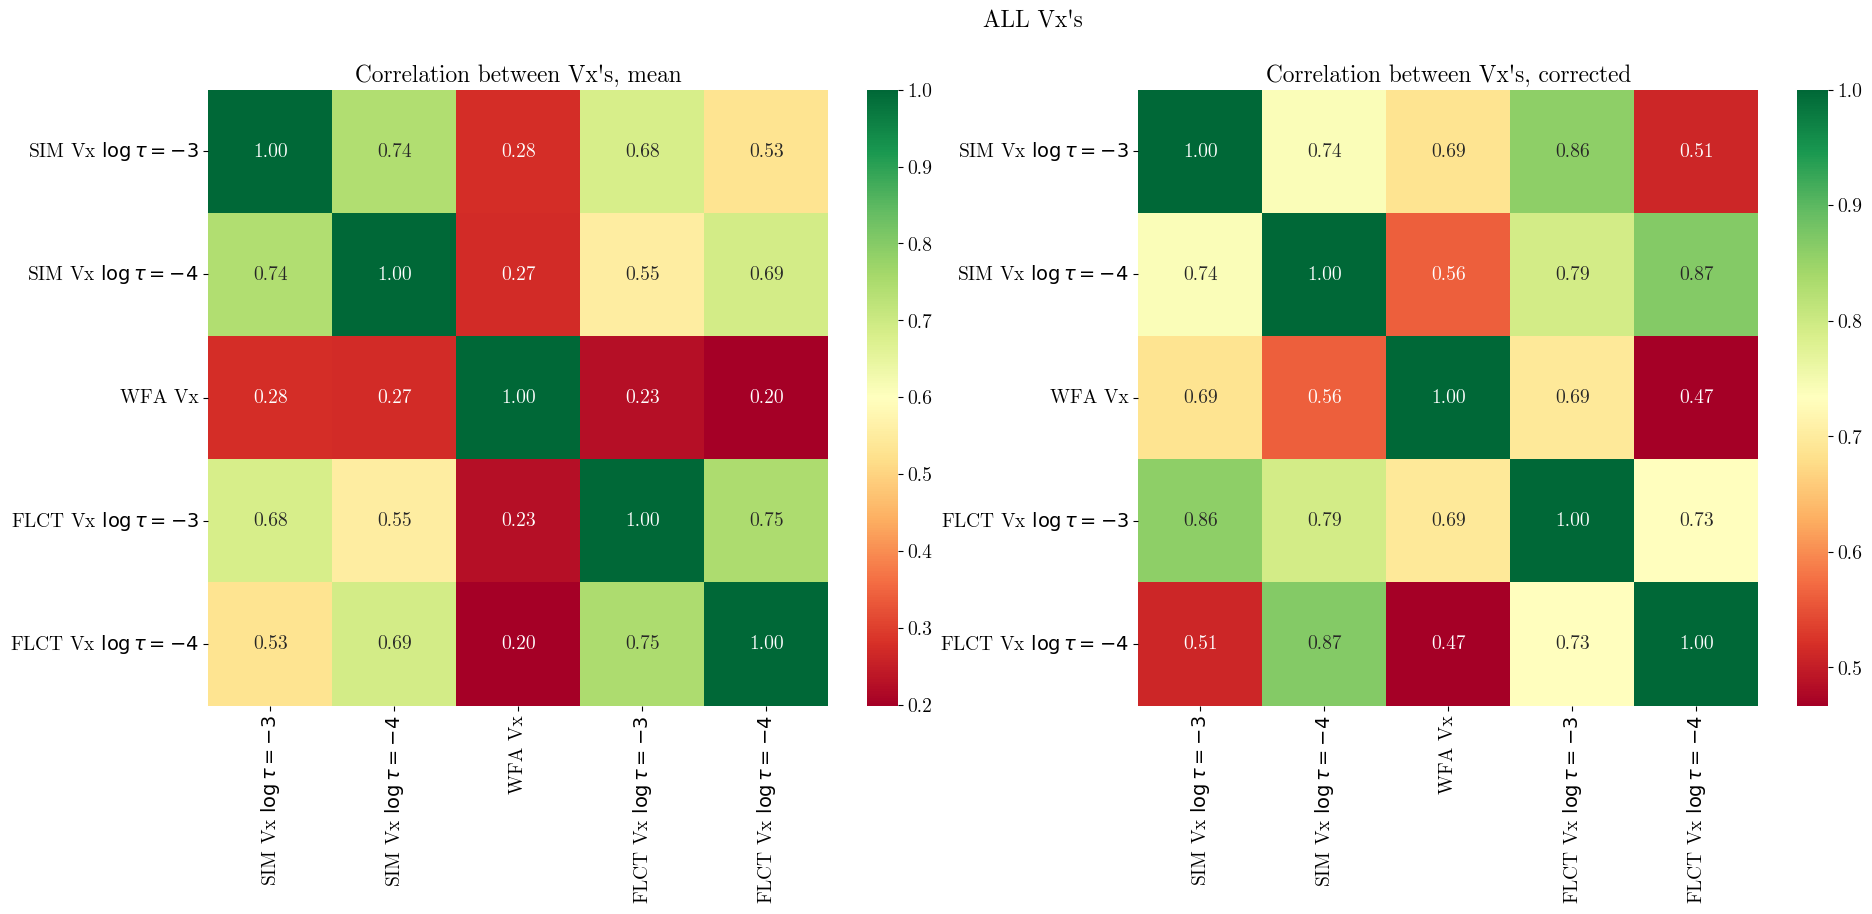

In [71]:
correlation_matrix = np.corrcoef([Vxm3_filtered600[:,:].ravel(), Vxm4_filtered600[:,:].ravel(),
                     Vx_BzMg_mean[:,:].ravel(), Vx_Bz3_mean[:,:].ravel(), 
                     Vx_Bz4_mean[:,:].ravel()])
fig = plt.figure(figsize = (22,8))
fig.suptitle("ALL Vx\'s")
ax1 = fig.add_subplot(121)
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='RdYlGn',
            xticklabels=['SIM Vx $\log\\tau = -3$', 'SIM Vx $\log\\tau = -4$', 'WFA Vx', 'FLCT Vx $\log\\tau = -3$', 'FLCT Vx $\log\\tau = -4$'],
            yticklabels=['SIM Vx $\log\\tau = -3$', 'SIM Vx $\log\\tau = -4$', 'WFA Vx', 'FLCT Vx $\log\\tau = -3$', 'FLCT Vx $\log\\tau = -4$'])
plt.title("Correlation between Vx\'s, mean")

correlation_matrix = np.corrcoef([Vxm3_filtered600[:,:].ravel(), Vxm4_filtered600[:,:].ravel(),
                     Vx_BzMgI_cor[:,:].ravel(), Vx_Bz3_cor[:,:].ravel(), 
                     Vx_Bz4_cor[:,:].ravel()])

ax2 = fig.add_subplot(122)
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='RdYlGn',
            xticklabels=['SIM Vx $\log\\tau = -3$', 'SIM Vx $\log\\tau = -4$', 'WFA Vx', 'FLCT Vx $\log\\tau = -3$', 'FLCT Vx $\log\\tau = -4$'],
            yticklabels=['SIM Vx $\log\\tau = -3$', 'SIM Vx $\log\\tau = -4$', 'WFA Vx', 'FLCT Vx $\log\\tau = -3$', 'FLCT Vx $\log\\tau = -4$'])
plt.title("Correlation between Vx\'s, corrected")
#plt.savefig("Correlatio_0_MgvsFe.png", dpi = 70)

Text(0.5, 1.0, "Correlation between Vy's, corrected")

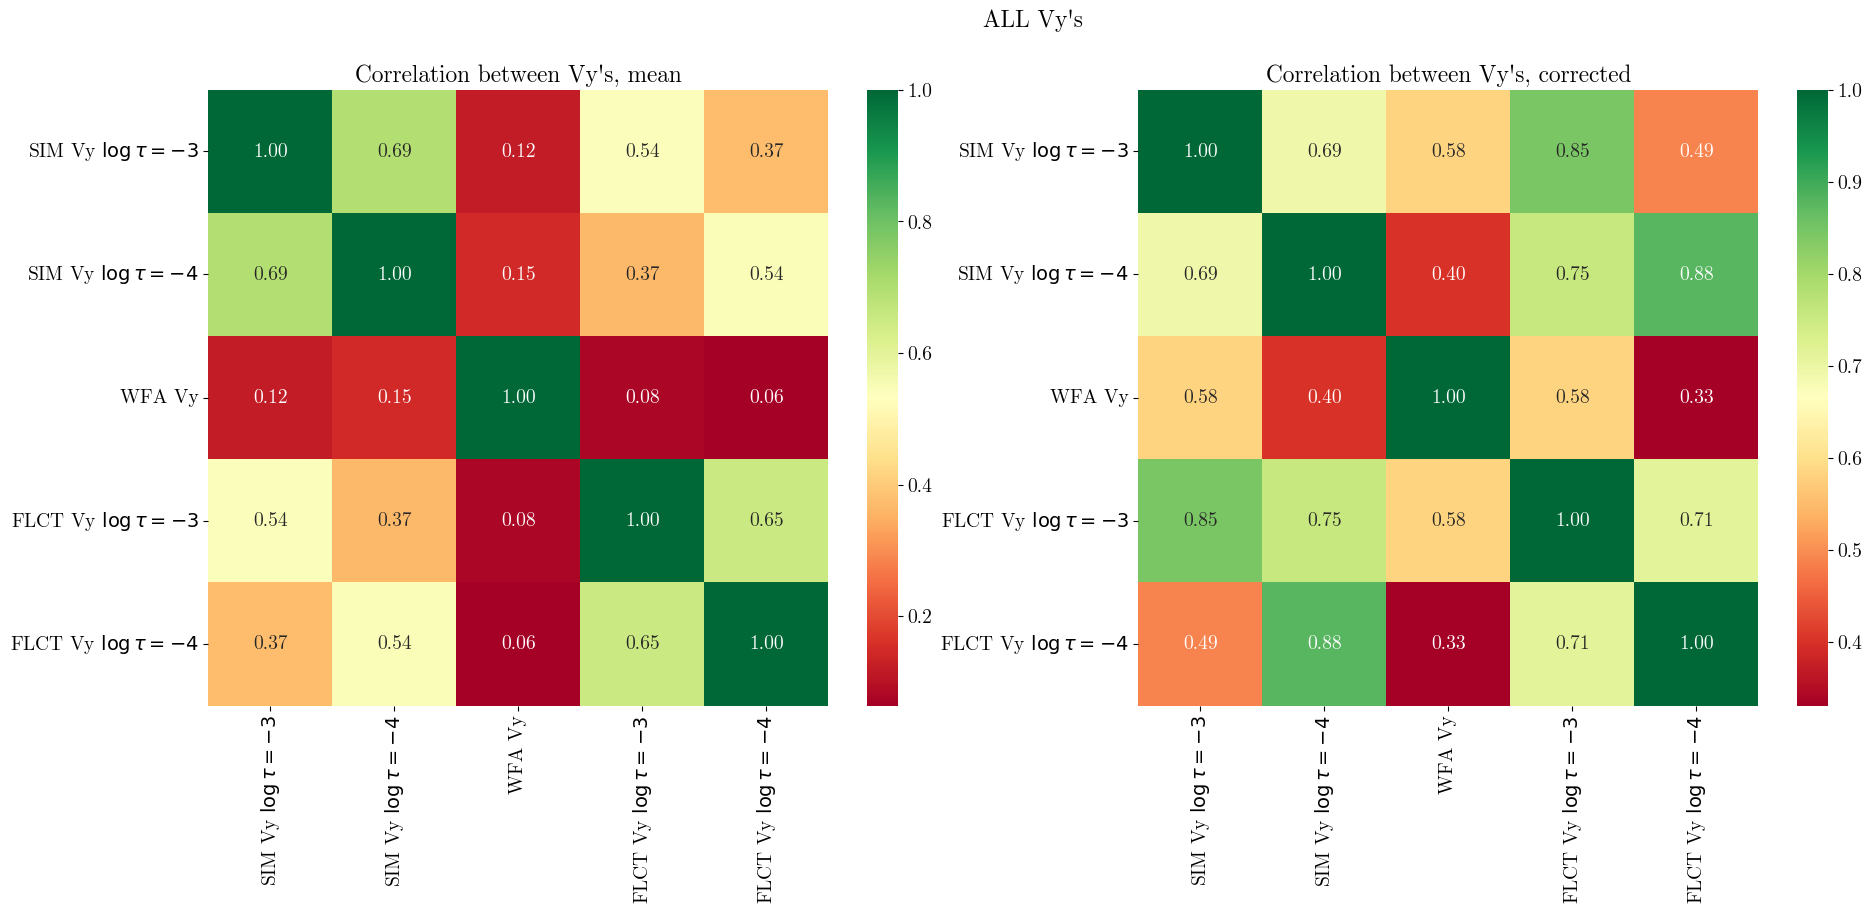

In [72]:
correlation_matrix = np.corrcoef([Vym3_filtered600[:,:].ravel(), Vym4_filtered600[:,:].ravel(),
                     Vy_BzMg_mean[:,:].ravel(), Vy_Bz3_mean[:,:].ravel(), 
                     Vy_Bz4_mean[:,:].ravel()])
fig = plt.figure(figsize = (22,8))
fig.suptitle("ALL Vy\'s")
ax1 = fig.add_subplot(121)
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='RdYlGn',
            xticklabels=['SIM Vy $\log\\tau = -3$', 'SIM Vy $\log\\tau = -4$', 'WFA Vy', 'FLCT Vy $\log\\tau = -3$', 'FLCT Vy $\log\\tau = -4$'],
            yticklabels=['SIM Vy $\log\\tau = -3$', 'SIM Vy $\log\\tau = -4$', 'WFA Vy', 'FLCT Vy $\log\\tau = -3$', 'FLCT Vy $\log\\tau = -4$'])
plt.title("Correlation between Vy\'s, mean")

correlation_matrix = np.corrcoef([Vym3_filtered600[:,:].ravel(), Vym4_filtered600[:,:].ravel(),
                     Vy_BzMgI_cor[:,:].ravel(), Vy_Bz3_cor[:,:].ravel(), 
                     Vy_Bz4_cor[:,:].ravel()])

ax2 = fig.add_subplot(122)
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='RdYlGn',
            xticklabels=['SIM Vy $\log\\tau = -3$', 'SIM Vy $\log\\tau = -4$', 'WFA Vy', 'FLCT Vy $\log\\tau = -3$', 'FLCT Vy $\log\\tau = -4$'],
            yticklabels=['SIM Vy $\log\\tau = -3$', 'SIM Vy $\log\\tau = -4$', 'WFA Vy', 'FLCT Vy $\log\\tau = -3$', 'FLCT Vy $\log\\tau = -4$'])
plt.title("Correlation between Vy\'s, corrected")
#plt.savefig("Correlatio_0_MgvsFe.png", dpi = 70)

<h3>FWHM = 300 km, $\log\tau = \{-3, -4\}$</h3>

In [73]:
Vxm3_filtered300 = gaussian_filter(Vxm3_mean, 11.25/2, mode = "wrap")
Vym3_filtered300 = gaussian_filter(Vym3_mean, 11.25/2, mode = "wrap")

In [74]:
Vxm4_filtered300 = gaussian_filter(Vxm4_mean, 11.25/2, mode = "wrap")
Vym4_filtered300 = gaussian_filter(Vym4_mean, 11.25/2, mode = "wrap")

In [75]:
Vx_Bz3_cor3 = mean_v_from_file("pyFLCT_vx_vy_fwhm_300_dt_30_logTaum3Bz_tracked.fits")
Vy_Bz3_cor3 = mean_vy_from_file("pyFLCT_vx_vy_fwhm_300_dt_30_logTaum3Bz_tracked.fits")

In [76]:
Vx_Bz4_cor3 = mean_v_from_file("pyFLCT_vx_vy_fwhm_300_dt_30_logTaum4Bz_tracked.fits")
Vy_Bz4_cor3 = mean_vy_from_file("pyFLCT_vx_vy_fwhm_300_dt_30_logTaum4Bz_tracked.fits")

In [77]:
Vx_Bz3_cor3 = Vx_Bz3_cor3[::2,::2]
Vy_Bz3_cor3 = Vy_Bz3_cor3[::2,::2]


#Vx_Bz3_cor3 = Vx_Bz3_cor3.reshape(768, 2, 768, 2)
#Vx_Bz3_cor3 = Vx_Bz3_cor3.mean(axis = 3).mean(axis = 1)

#Vy_Bz3_cor3 = Vy_Bz3_cor3.reshape(768, 2, 768, 2)
#Vy_Bz3_cor3 = Vy_Bz3_cor3.mean(axis = 3).mean(axis = 1)


In [78]:
Vx_Bz4_cor3 = Vx_Bz4_cor3[::2,::2]
Vy_Bz4_cor3 = Vy_Bz4_cor3[::2,::2]


#Vx_Bz4_cor3 = Vx_Bz4_cor3.reshape(768, 2, 768, 2)
#Vx_Bz4_cor3 = Vx_Bz4_cor3.mean(axis = 3).mean(axis = 1)

#Vy_Bz4_cor3 = Vy_Bz4_cor3.reshape(768, 2, 768, 2)
#Vy_Bz4_cor3 = Vy_Bz4_cor3.mean(axis = 3).mean(axis = 1)


Text(0.5, 1.0, "Correlation between Vx's, corrected")

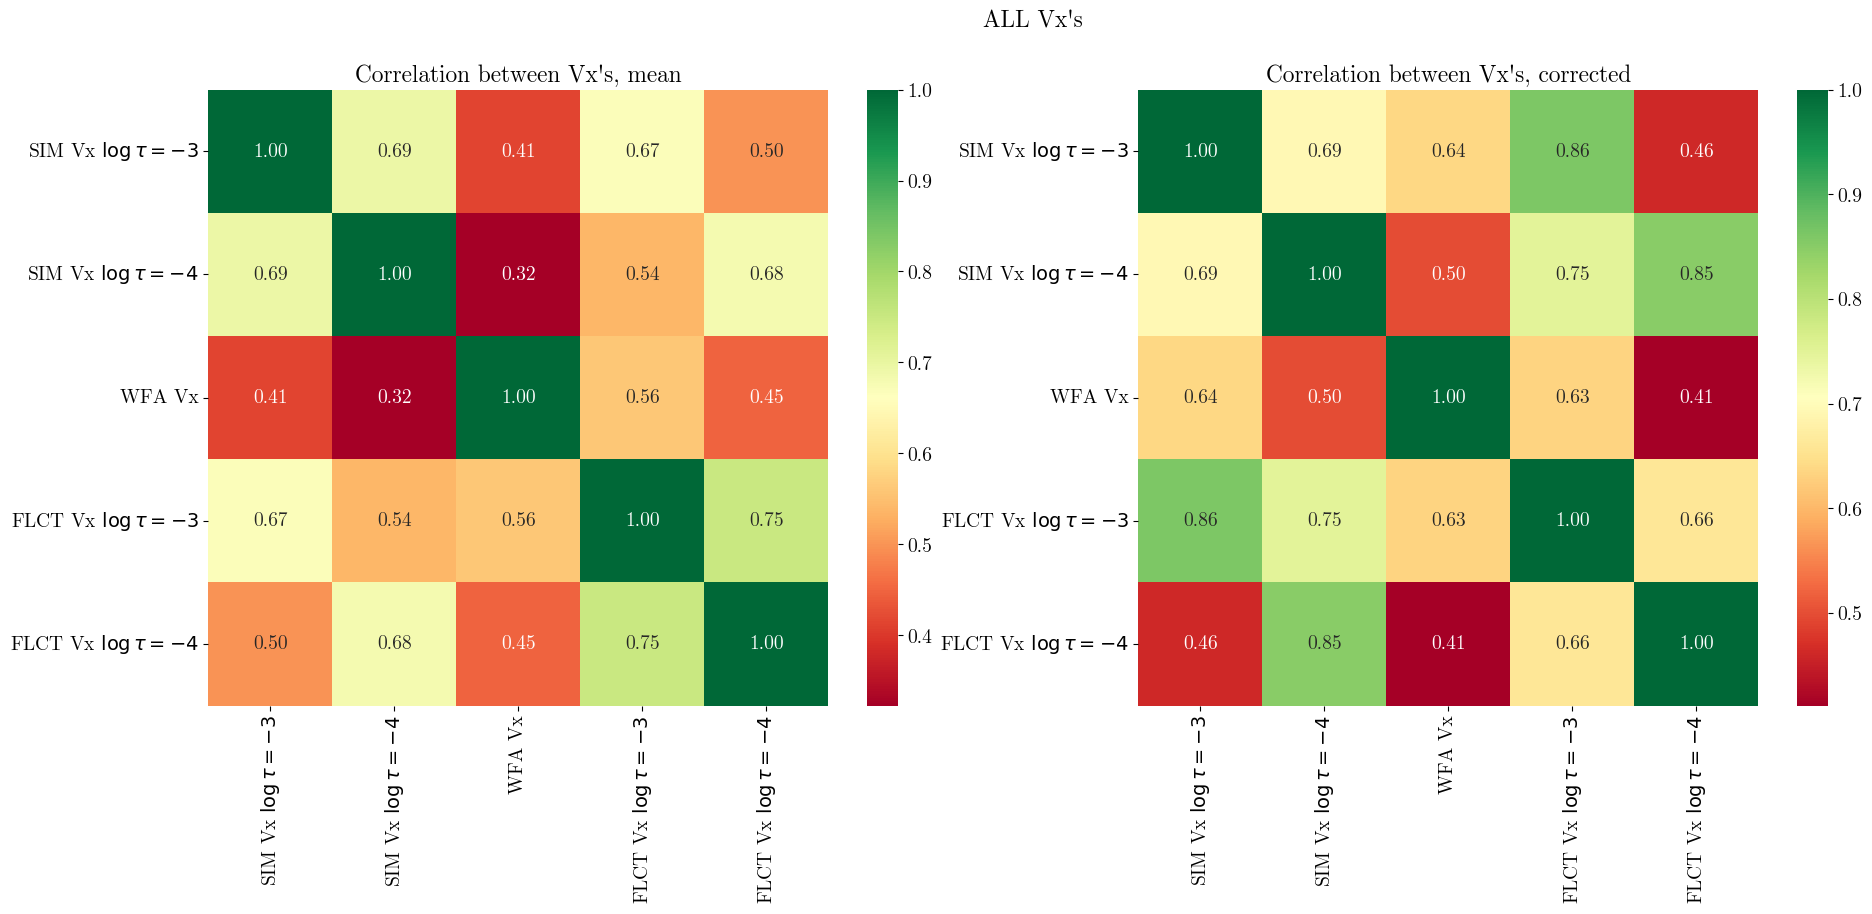

In [79]:
correlation_matrix = np.corrcoef([Vxm3_filtered300[:,:].ravel(), Vxm4_filtered300[:,:].ravel(),
                     Vx_BzMgI3_mean[:,:].ravel(), Vx_Bz3_mean[:,:].ravel(), 
                     Vx_Bz4_mean[:,:].ravel()])
fig = plt.figure(figsize = (22,8))
fig.suptitle("ALL Vx\'s")
ax1 = fig.add_subplot(121)
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='RdYlGn',
            xticklabels=['SIM Vx $\log\\tau = -3$', 'SIM Vx $\log\\tau = -4$', 'WFA Vx', 'FLCT Vx $\log\\tau = -3$', 'FLCT Vx $\log\\tau = -4$'],
            yticklabels=['SIM Vx $\log\\tau = -3$', 'SIM Vx $\log\\tau = -4$', 'WFA Vx', 'FLCT Vx $\log\\tau = -3$', 'FLCT Vx $\log\\tau = -4$'])
plt.title("Correlation between Vx\'s, mean")

correlation_matrix = np.corrcoef([Vxm3_filtered300[:,:].ravel(), Vxm4_filtered300[:,:].ravel(),
                     Vx_BzMgI_cor3[:,:].ravel(), Vx_Bz3_cor3[:,:].ravel(), 
                     Vx_Bz4_cor3[:,:].ravel()])

ax2 = fig.add_subplot(122)
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='RdYlGn',
            xticklabels=['SIM Vx $\log\\tau = -3$', 'SIM Vx $\log\\tau = -4$', 'WFA Vx', 'FLCT Vx $\log\\tau = -3$', 'FLCT Vx $\log\\tau = -4$'],
            yticklabels=['SIM Vx $\log\\tau = -3$', 'SIM Vx $\log\\tau = -4$', 'WFA Vx', 'FLCT Vx $\log\\tau = -3$', 'FLCT Vx $\log\\tau = -4$'])
plt.title("Correlation between Vx\'s, corrected")
#plt.savefig("Correlatio_0_MgvsFe.png", dpi = 70)

Text(0.5, 1.0, "Correlation between Vy's, corrected")

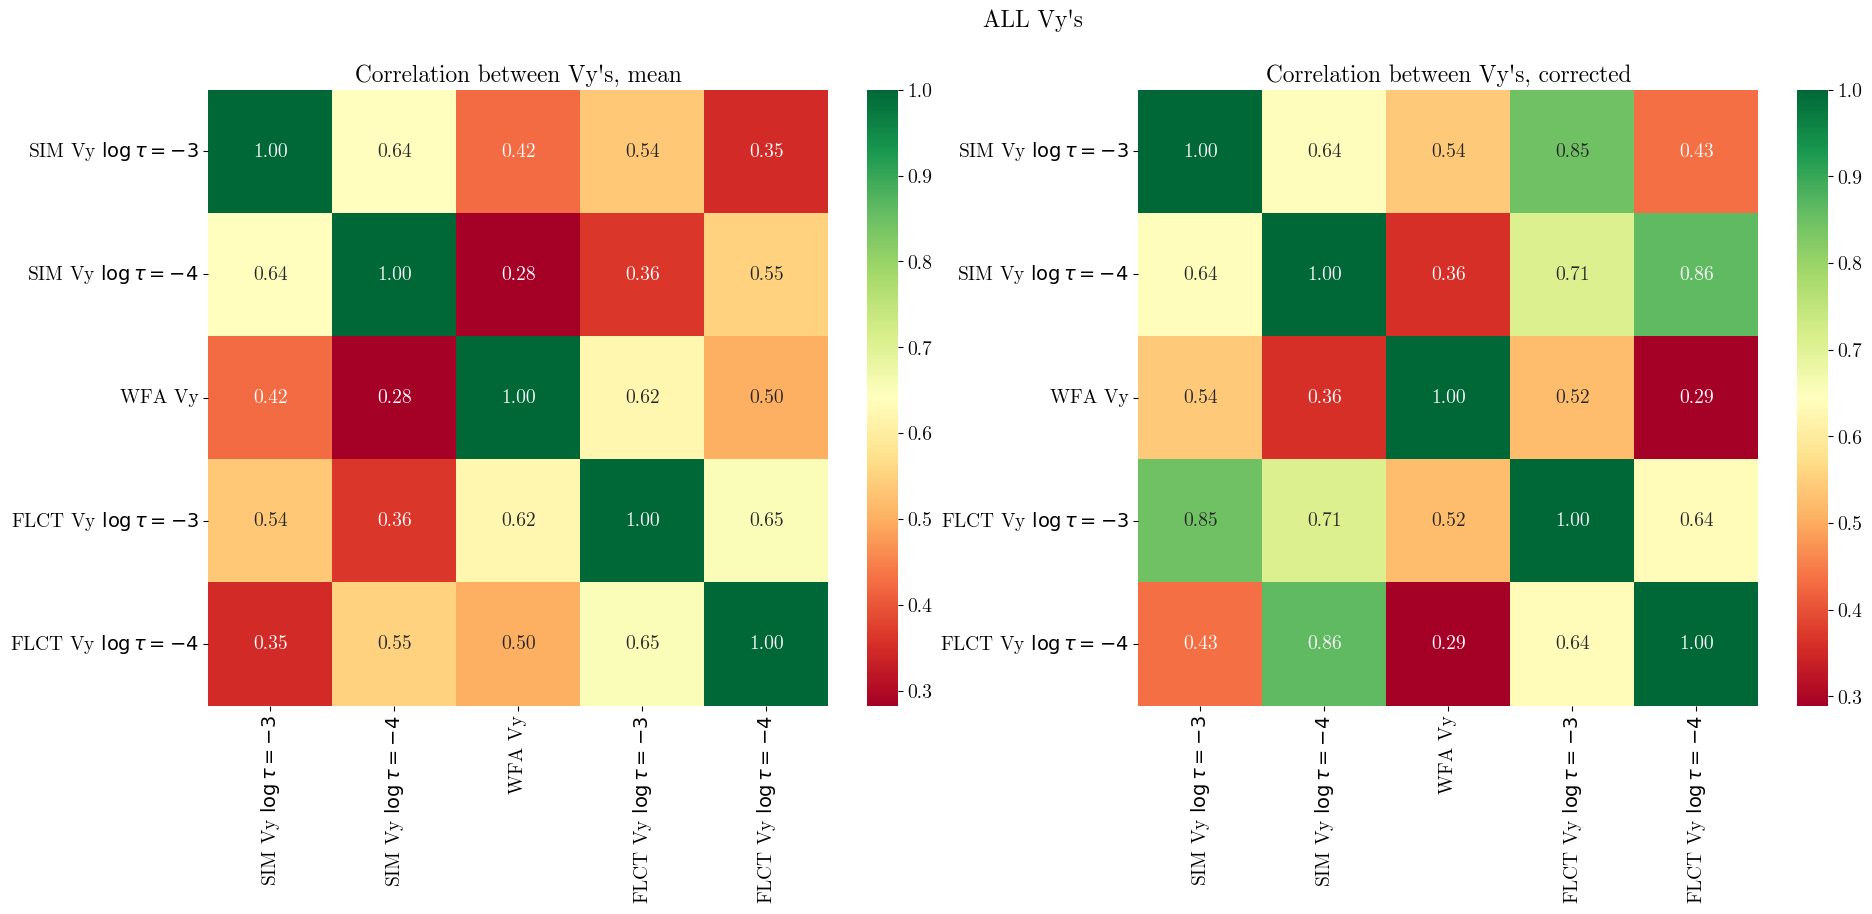

In [80]:
correlation_matrix = np.corrcoef([Vym3_filtered300[:,:].ravel(), Vym4_filtered300[:,:].ravel(),
                     Vy_BzMgI3_mean[:,:].ravel(), Vy_Bz3_mean[:,:].ravel(), 
                     Vy_Bz4_mean[:,:].ravel()])
fig = plt.figure(figsize = (22,8))
fig.suptitle("ALL Vy\'s")
ax1 = fig.add_subplot(121)
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='RdYlGn',
            xticklabels=['SIM Vy $\log\\tau = -3$', 'SIM Vy $\log\\tau = -4$', 'WFA Vy', 'FLCT Vy $\log\\tau = -3$', 'FLCT Vy $\log\\tau = -4$'],
            yticklabels=['SIM Vy $\log\\tau = -3$', 'SIM Vy $\log\\tau = -4$', 'WFA Vy', 'FLCT Vy $\log\\tau = -3$', 'FLCT Vy $\log\\tau = -4$'])
plt.title("Correlation between Vy\'s, mean")

correlation_matrix = np.corrcoef([Vym3_filtered300[:,:].ravel(), Vym4_filtered300[:,:].ravel(),
                     Vy_BzMgI_cor3[:,:].ravel(), Vy_Bz3_cor3[:,:].ravel(), 
                     Vy_Bz4_cor3[:,:].ravel()])

ax2 = fig.add_subplot(122)
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='RdYlGn',
            xticklabels=['SIM Vy $\log\\tau = -3$', 'SIM Vy $\log\\tau = -4$', 'WFA Vy', 'FLCT Vy $\log\\tau = -3$', 'FLCT Vy $\log\\tau = -4$'],
            yticklabels=['SIM Vy $\log\\tau = -3$', 'SIM Vy $\log\\tau = -4$', 'WFA Vy', 'FLCT Vy $\log\\tau = -3$', 'FLCT Vy $\log\\tau = -4$'])
plt.title("Correlation between Vy\'s, corrected")
#plt.savefig("Correlatio_0_MgvsFe.png", dpi = 70)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


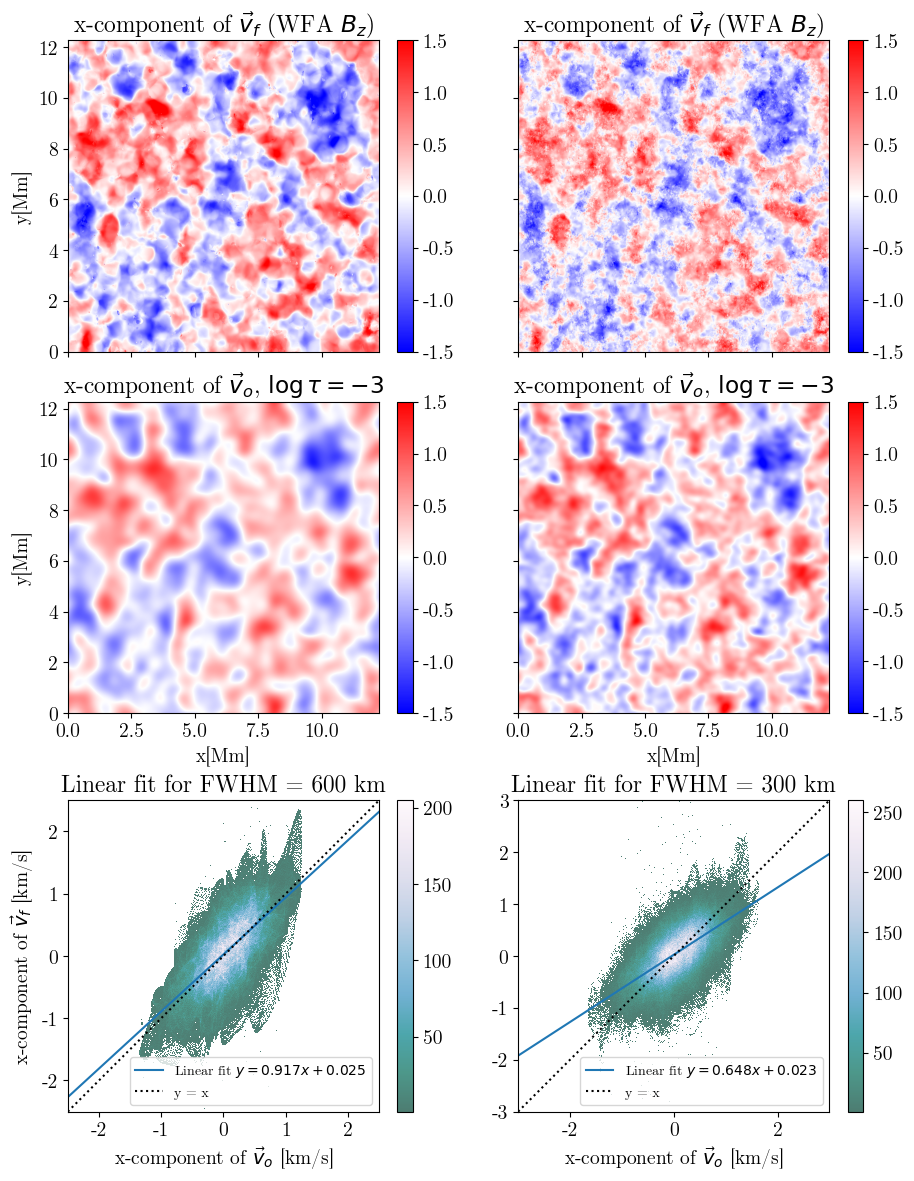

In [81]:
#fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(14, 8))
f = plt.figure(constrained_layout=True, figsize = (9, 11.7))
#plt.suptitle("Linear fit of FLCT Vx and convolved Vx from simulation for FHWM = {1200, 600, 300, 100}km")
# 4x3 plot, velicina A, velicina B, scatter A i B!!!
#ax1 = plt.subplot2grid((4,3), (0,0))
ax1 = f.add_subplot(321)
ax1.set_title("x-component of $\\vec{v}_f$ (WFA $B_z$)")
#ax1.set_xlabel("x[Mm]")
ax1.set_ylabel("y[Mm]")
ax1.set_xticklabels([])
im1 = ax1.imshow(Vx_BzMgI_cor[:, :].T, origin='lower', cmap = "bwr", extent = (0, 12.268, 0, 12.268), vmin = -1.5, vmax = 1.5)
plt.colorbar(im1)

#ax2 = plt.subplot2grid((4,3), (0,1))
ax2 = f.add_subplot(323)
ax2.set_title("x-component of $\\vec{v}_o$, $\log\\tau = -3$")
ax2.set_xlabel("x[Mm]")
ax2.set_ylabel("y[Mm]")
im2 = ax2.imshow(Vxm3_filtered600[:, :].T, origin='lower', cmap = "bwr", extent = (0, 12.268, 0, 12.268), vmin = -1.5, vmax = 1.5)
plt.colorbar(im2)

#ax3 = plt.subplot2grid((4,3), (0,2))
ax3 = f.add_subplot(325)
ax3.set_title("Linear fit for FWHM = 600 km")                                
ax3.set_ylabel("x-component of $\\vec{v}_f$ [km/s]")
ax3.set_xlabel("x-component of $\\vec{v}_o$ [km/s]")
#ax3.scatter(Vxm3_filtered600.flatten(), Vx_BzMgI_cor.flatten(), s = 0.01, alpha = 0.05, color="red")

df = pd.DataFrame(dict(x = Vxm3_filtered600.flatten(), y = Vx_BzMgI_cor.flatten()))
dsartist = dsshow(
        df,
        ds.Point("x", "y"),
        ds.count(),
        #vmin=np.min(z),
        #vmax=np.max(z),
        alpha = 0.7,
        norm="linear",
        aspect="equal",
        ax=ax3,
        cmap = "PuBuGn_r",
        x_range = (-4,4),
        y_range = (-4,4)
    )

m3, b3, *_ = linregress(Vxm3_filtered600.flatten(), Vx_BzMgI_cor.flatten())
ax3.axline(xy1=(0, b3), slope=m3, label=f'Linear fit $y = {m3:.3f}x {b3:+.3f}$')
ax3.plot([0,1],[0,1], linestyle='dotted', color='k', transform=ax3.transAxes, label = "y = x")
ax3.set_xlim(-2.5, 2.5)
ax3.set_ylim(-2.5, 2.5)
plt.colorbar(dsartist)
plt.legend(fontsize = 10, loc = "lower right")

#ax4 = plt.subplot2grid((4,3), (1,0))
ax4 = f.add_subplot(322)
ax4.set_title("x-component of $\\vec{v}_f$ (WFA $B_z$)")
#ax4.set_xlabel("x[Mm]")
#ax4.set_ylabel("y[Mm]")
ax4.set_xticklabels([])
ax4.set_yticklabels([])
im4 = ax4.imshow(Vx_BzMgI_cor3[:, :].T, origin='lower', cmap = "bwr", extent = (0, 12.268, 0, 12.268), vmin = -1.5, vmax = 1.5)
plt.colorbar(im4)

#ax5 = plt.subplot2grid((4,3), (1,1))
ax5 = f.add_subplot(324)
ax5.set_title("x-component of $\\vec{v}_o$, $\log\\tau = -3$")
ax5.set_xlabel("x[Mm]")
#ax5.set_ylabel("y[Mm]")
ax5.set_yticklabels([])
im5 = ax5.imshow(Vxm3_filtered300[:, :].T, origin='lower', cmap = "bwr", extent = (0, 12.268, 0, 12.268), vmin = -1.5, vmax = 1.5)
plt.colorbar(im5)

#ax6 = plt.subplot2grid((4,3), (1,2))
ax6 = f.add_subplot(326)
ax6.set_title("Linear fit for FWHM = 300 km")                                
#ax6.set_ylabel("FLCT Vx[km/s]")
ax6.set_xlabel("x-component of $\\vec{v}_o$ [km/s]")
#ax6.scatter(Vxm3_filtered300.flatten(), Vx_BzMgI_cor3.flatten(), s = 0.01, alpha = 0.05, color="red")

df1 = pd.DataFrame(dict(x = Vxm3_filtered300.flatten(), y = Vx_BzMgI_cor3.flatten()))
dsartist1 = dsshow(
        df1,
        ds.Point("x", "y"),
        ds.count(),
        #vmin=np.min(z),
        #vmax=np.max(z),
        alpha = 0.7,
        norm="linear",
        aspect="equal",
        ax=ax6,
        cmap = "PuBuGn_r",
        #cmap = "inferno"
        x_range = (-4,4),
        y_range = (-4,4)
    )

m4, b4, *_ = linregress(Vxm3_filtered300.flatten(), Vx_BzMgI_cor3.flatten())
ax6.axline(xy1=(0, b4), slope=m4, label=f'Linear fit $y = {m4:.3f}x {b4:+.3f}$')
ax6.plot([0,1],[0,1], linestyle='dotted', color='k', transform=ax6.transAxes, label = "y = x")
ax6.set_xlim(-3.0, 3.0)
ax6.set_ylim(-3.0, 3.0)
plt.colorbar(dsartist1)
plt.legend(fontsize = 10, loc = "lower right")



#plt.tight_layout()
plt.savefig("300_600_%2compMgI_taum3.png", dpi = 100, bbox_inches = 'tight')
plt.savefig("300_600_%2compMgI_taum3.eps", dpi = 100, bbox_inches = 'tight')
plt.savefig("300_600_%2compMgI_taum3.pdf", dpi = 150, bbox_inches = 'tight')

<h2>27. 03. 2025. - CS calculaction</h2>

In [82]:
from numpy import dot
from numpy.linalg import norm
def CS_calc(a, b):
    s = 0
    for j in range(len(a)):
        cos_sim = dot(a[j], b[j])/(norm(a[j])*norm(b[j]))
        s = s + cos_sim
    return s/len(a)

<h3>FWHM = 600 km, all $\tau$-s</h3>

In [83]:
cs_1_MG_600 = CS_calc(Vxm1_filtered600.flatten(), Vx_BzMgI_cor.flatten())
print(cs_1_MG_600)

0.3230624728732639


In [84]:
cs_1_MG_600y = CS_calc(Vym1_filtered600.flatten(), Vy_BzMgI_cor.flatten())
print(cs_1_MG_600y)

0.26361083984375


In [85]:
cs_2_MG_600 = CS_calc(Vxm2_filtered600.flatten(), Vx_BzMgI_cor.flatten())
print(cs_2_MG_600)

0.3788282606336806


In [86]:
cs_2_MG_600y = CS_calc(Vym2_filtered600.flatten(), Vy_BzMgI_cor.flatten())
print(cs_2_MG_600y)

0.3160841200086806


In [87]:
cs_3_MG_600 = CS_calc(Vxm3_filtered600.flatten(), Vx_BzMgI_cor.flatten())
print(cs_3_MG_600)

0.5099894205729166


In [88]:
cs_3_MG_600y = CS_calc(Vym3_filtered600.flatten(), Vy_BzMgI_cor.flatten())
print(cs_3_MG_600y)

0.4128316243489583


In [89]:
cs_4_MG_600 = CS_calc(Vxm4_filtered600.flatten(), Vx_BzMgI_cor.flatten())
print(cs_4_MG_600)

0.37548828125


In [90]:
cs_4_MG_600y = CS_calc(Vym4_filtered600.flatten(), Vy_BzMgI_cor.flatten())
print(cs_4_MG_600y)

0.2702704535590278


<h3>FWHM = 300km, all $\tau$-s</h3>

In [91]:
cs_1_MG_300 = CS_calc(Vxm1_filtered300.flatten(), Vx_BzMgI_cor3.flatten())
print(cs_1_MG_300)

0.2748345269097222


In [92]:
cs_1_MG_300y = CS_calc(Vym1_filtered300.flatten(), Vy_BzMgI_cor3.flatten())
print(cs_1_MG_300y)

0.226837158203125


In [93]:
cs_2_MG_300 = CS_calc(Vxm2_filtered300.flatten(), Vx_BzMgI_cor3.flatten())
print(cs_2_MG_300)

0.3301425509982639


In [94]:
cs_2_MG_300y = CS_calc(Vym2_filtered300.flatten(), Vy_BzMgI_cor3.flatten())
print(cs_2_MG_300y)

0.2708909776475694


In [95]:
cs_3_MG_300 = CS_calc(Vxm3_filtered300.flatten(), Vx_BzMgI_cor3.flatten())
print(cs_3_MG_300)

0.4645792643229167


In [96]:
cs_3_MG_300y = CS_calc(Vym3_filtered300.flatten(), Vy_BzMgI_cor3.flatten())
print(cs_3_MG_300y)

0.3767496744791667


In [97]:
cs_4_MG_300 = CS_calc(Vxm4_filtered300.flatten(), Vx_BzMgI_cor3.flatten())
print(cs_4_MG_300)

0.3357204861111111


In [98]:
cs_4_MG_300y = CS_calc(Vym4_filtered300.flatten(), Vy_BzMgI_cor3.flatten())
print(cs_4_MG_300y)

0.24736531575520834


<h2>01. 04. 2025.</h2>

<h3>FWHM = 600, 300 km, Table 4 as plot</h3>

In [99]:
logt = [-1.0, -2.0, -3.0, -4.0]
fwhm6x_cor = [pearsonr(Vxm1_filtered600.flatten(), Vx_BzMgI_cor.flatten())[0],
            pearsonr(Vxm2_filtered600.flatten(), Vx_BzMgI_cor.flatten())[0],
             pearsonr(Vxm3_filtered600.flatten(), Vx_BzMgI_cor.flatten())[0],
             pearsonr(Vxm4_filtered600.flatten(), Vx_BzMgI_cor.flatten())[0]]
fwhm6y_cor = [pearsonr(Vym1_filtered600.flatten(), Vy_BzMgI_cor.flatten())[0],
            pearsonr(Vym2_filtered600.flatten(), Vy_BzMgI_cor.flatten())[0],
             pearsonr(Vym3_filtered600.flatten(), Vy_BzMgI_cor.flatten())[0],
             pearsonr(Vym4_filtered600.flatten(), Vy_BzMgI_cor.flatten())[0]]

fwhm3x_cor = [pearsonr(Vxm1_filtered300.flatten(), Vx_BzMgI_cor3.flatten())[0],
            pearsonr(Vxm2_filtered300.flatten(), Vx_BzMgI_cor3.flatten())[0],
             pearsonr(Vxm3_filtered300.flatten(), Vx_BzMgI_cor3.flatten())[0],
             pearsonr(Vxm4_filtered300.flatten(), Vx_BzMgI_cor3.flatten())[0]]

fwhm3y_cor = [pearsonr(Vym1_filtered300.flatten(), Vy_BzMgI_cor3.flatten())[0],
            pearsonr(Vym2_filtered300.flatten(), Vy_BzMgI_cor3.flatten())[0],
             pearsonr(Vym3_filtered300.flatten(), Vy_BzMgI_cor3.flatten())[0],
             pearsonr(Vym4_filtered300.flatten(), Vy_BzMgI_cor3.flatten())[0]]

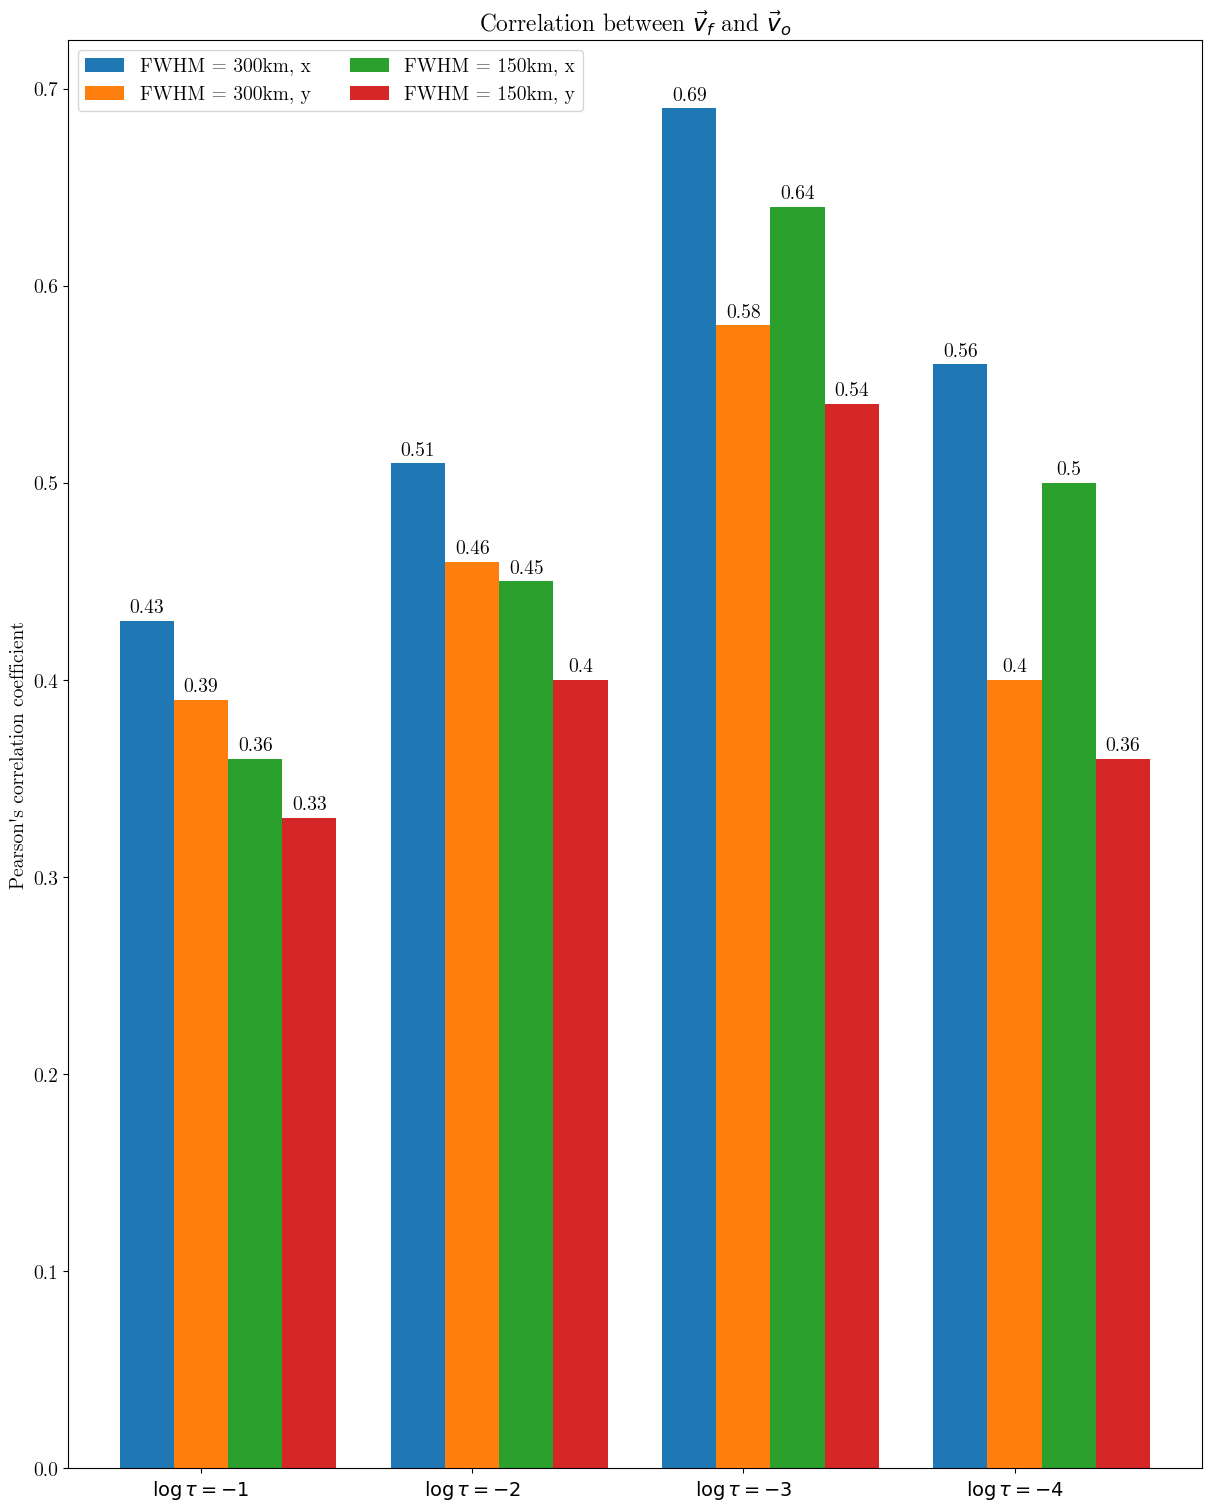

In [100]:
species = ("$\log\\tau=-1$", "$\log\\tau=-2$", "$\log\\tau=-3$", "$\log\\tau=-4$")
penguin_means = {
    'FWHM = 300km, x': (round(fwhm6x_cor[0],2), round(fwhm6x_cor[1],2), round(fwhm6x_cor[2],2), round(fwhm6x_cor[3],2)),
    'FWHM = 300km, y': (round(fwhm6y_cor[0],2), round(fwhm6y_cor[1],2), round(fwhm6y_cor[2],2), round(fwhm6y_cor[3],2)),
    'FWHM = 150km, x': (round(fwhm3x_cor[0],2), round(fwhm3x_cor[1],2), round(fwhm3x_cor[2],2), round(fwhm3x_cor[3],2)),
    'FWHM = 150km, y': (round(fwhm3y_cor[0],2), round(fwhm3y_cor[1],2), round(fwhm3y_cor[2],2), round(fwhm3y_cor[3],2)),
}


x = np.arange(len(species))  # the label locations
width = 0.20  # the width of the bars
multiplier = 0

fig, ax = plt.subplots(figsize = (12,15), layout='constrained')

for attribute, measurement in penguin_means.items():
    offset = width * multiplier
    rects = ax.bar(x + offset, measurement, width, label=attribute)
    ax.bar_label(rects, padding=3)
    multiplier += 1

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel("Pearson's correlation coefficient")
ax.set_title('Correlation between $\\vec{v}_f$ and $\\vec{v}_o$')
ax.set_xticks(x + width, species)
ax.legend(loc='upper left', ncols=2)
plt.savefig("Table4.png", dpi = 200, bbox_inches = 'tight')

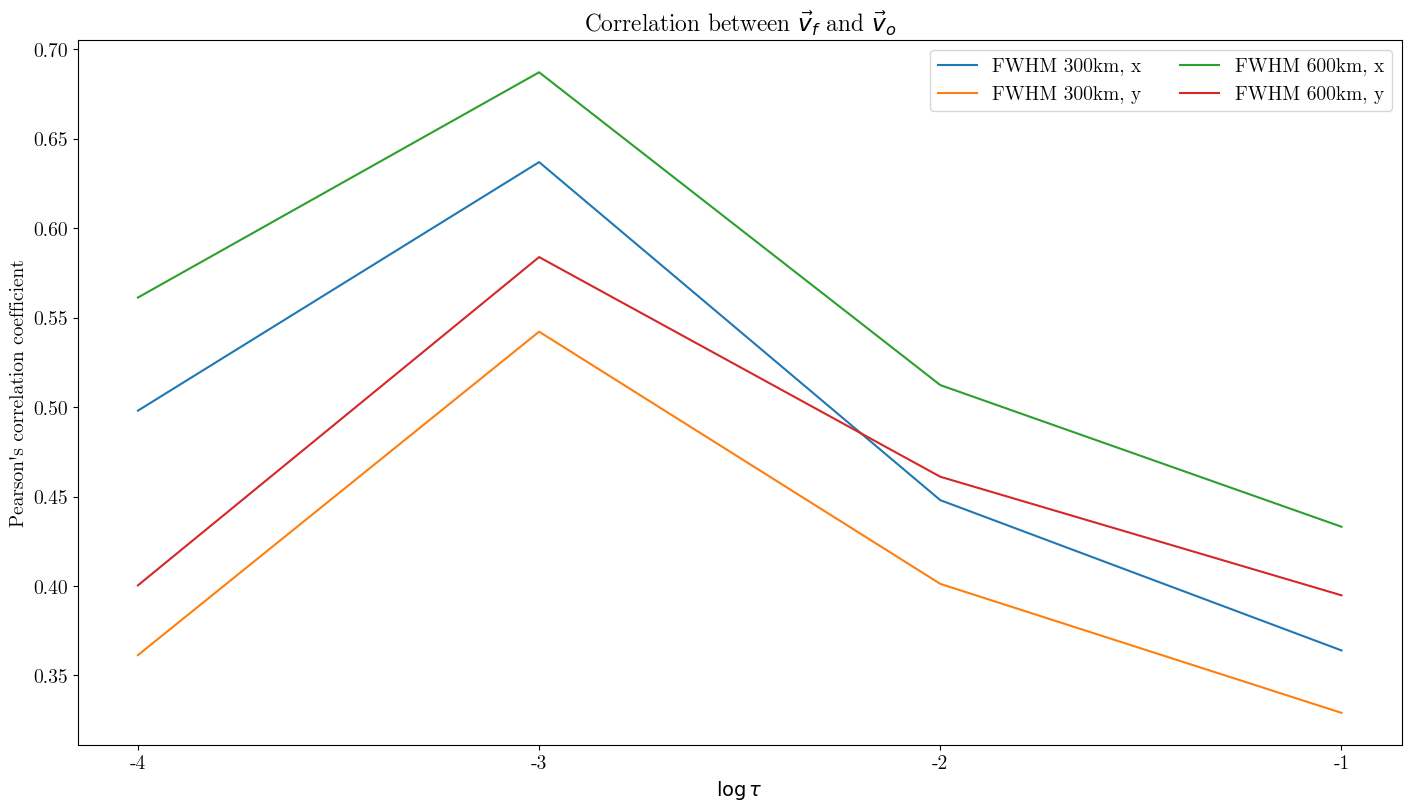

In [101]:
#plt.rc('axes', unicode_minus=True)
fig, ax = plt.subplots(figsize = (14,8), layout='constrained')
ax.plot(logt, fwhm3x_cor, label="FWHM 300km, x")
ax.plot(logt, fwhm3y_cor, label = "FWHM 300km, y")
ax.plot(logt, fwhm6x_cor, label = "FWHM 600km, x")
ax.plot(logt, fwhm6y_cor, label = "FWHM 600km, y")
ax.set_ylabel("Pearson's correlation coefficient")
ax.set_title('Correlation between $\\vec{v}_f$ and $\\vec{v}_o$')
ax.set_xlabel("$\log\\tau$")
ax.set_xticks([-1,-2,-3,-4])
ax.legend(loc='best', ncols=2)
#plt.semilogx([0.1, 0.01, 0.001, 0.0001], fwhm6x_cor)

In [102]:
def divergence(f,h):
    """
    div(F) = dFx/dx + dFy/dy + ...
    g = np.gradient(Fx,dx, axis=1)+ np.gradient(Fy,dy, axis=0) #2D
    g = np.gradient(Fx,dx, axis=2)+ np.gradient(Fy,dy, axis=1) +np.gradient(Fz,dz,axis=0) #3D
    """
    num_dims = len(f)
    return np.ufunc.reduce(np.add, [np.gradient(f[i], h[i], axis=i) for i in range(num_dims)])

#def divergence(f,sp):
#        num_dims = len(f)
#        return np.ufunc.reduce(np.add, [np.gradient(f[i], sp[i], axis=i) for i in range(num_dims)])

In [103]:
NY = len(Vym1_filtered600)
ymin = np.min(Vym1_filtered600)
ymax = np.max(Vym1_filtered600)
dy = (ymax -ymin )/(NY-1.)

NX = NY
xmin = np.min(Vxm1_filtered600)
xmax = np.max(Vxm1_filtered600)
dx = (xmax -xmin)/(NX-1.)


x = np.linspace(xmin,xmax, NX)
y = np.linspace(ymin,ymax, NY)
xx, yy = np.meshgrid(x, y)

h_x = np.diff(x)[0]
h_y = np.diff(y)[0]

Fx  = Vxm1_filtered600
Fy  = Vym1_filtered600

F = [Fx, Fy]
#h = [dx, dy]
h = [32, 32]
#g1 = divergence(F,h)
g1 = divv(Fx, Fy, 32)

NY = len(Vy_BzMgI_cor)
ymin = np.min(Vy_BzMgI_cor)
ymax = np.max(Vy_BzMgI_cor)
dy = (ymax -ymin )/(NY-1.)

NX = NY
xmin = np.min(Vx_BzMgI_cor)
xmax = np.max(Vx_BzMgI_cor)
dx = (xmax -xmin)/(NX-1.)

x = np.linspace(xmin,xmax, NX)
y = np.linspace(ymin,ymax, NY)
xx, yy = np.meshgrid(x, y)

h_x = np.diff(x)[0]
h_y = np.diff(y)[0]

Fx  = Vx_BzMgI_cor
Fy  = Vy_BzMgI_cor

F = [Fx, Fy]
#h = [dx, dy]
h = [32, 32]
#g11 = divergence(F,h)
g11 = divv(Fx, Fy, 32)

div_600t1 = pearsonr(g1.flatten(), g11.flatten())
print(div_600t1)

cs_div1_Mg_600 = CS_calc(g1.flatten(), g11.flatten())
print("Cauchy-Schwartz: {}".format(cs_div1_Mg_600))

PearsonRResult(statistic=np.float64(0.13638539310883888), pvalue=np.float64(0.0))
Cauchy-Schwartz: 0.08491685655381945


In [104]:
NY = len(Vym2_filtered600)
ymin = np.min(Vym2_filtered600)
ymax = np.max(Vym2_filtered600)
dy = (ymax -ymin )/(NY-1.)

NX = NY
xmin = np.min(Vxm2_filtered600)
xmax = np.max(Vxm2_filtered600)
dx = (xmax -xmin)/(NX-1.)

x = np.linspace(xmin,xmax, NX)
y = np.linspace(ymin,ymax, NY)
xx, yy = np.meshgrid(x, y)

h_x = np.diff(x)[0]
h_y = np.diff(y)[0]

Fx  = Vxm2_filtered600
Fy  = Vym2_filtered600

F = [Fx, Fy]
#h = [dx, dy]
h = [32, 32]
#g2 = divergence(F,h)
g2 = divv(Fx, Fy, 32)


div_600t2 = pearsonr(g2.flatten(), g11.flatten())
print(div_600t2)

cs_div2_Mg_600 = CS_calc(g2.flatten(), g11.flatten())
print("Cauchy-Schwartz: {}".format(cs_div2_Mg_600))

PearsonRResult(statistic=np.float64(0.16152495766505218), pvalue=np.float64(0.0))
Cauchy-Schwartz: 0.11002604166666667


In [105]:
NY = len(Vym3_filtered600)
ymin = np.min(Vym3_filtered600)
ymax = np.max(Vym3_filtered600)
dy = (ymax -ymin )/(NY-1.)

NX = NY
xmin = np.min(Vxm3_filtered600)
xmax = np.max(Vxm3_filtered600)
dx = (xmax -xmin)/(NX-1.)

x = np.linspace(xmin,xmax, NX)
y = np.linspace(ymin,ymax, NY)
xx, yy = np.meshgrid(x, y)

h_x = np.diff(x)[0]
h_y = np.diff(y)[0]

Fx  = Vxm3_filtered600
Fy  = Vym3_filtered600

F = [Fx, Fy]
#h = [dx, dy]
h = [32, 32]
#g3 = divergence(F,h)
g3 = divv(Fx, Fy, 32)


div_600t3 = pearsonr(g3.flatten(), g11.flatten())
print(div_600t3)

cs_div3_Mg_600 = CS_calc(g3.flatten(), g11.flatten())
print("Cauchy-Schwartz: {}".format(cs_div3_Mg_600))

PearsonRResult(statistic=np.float64(0.22930258500983028), pvalue=np.float64(0.0))
Cauchy-Schwartz: 0.1898430718315972


In [106]:
NY = len(Vym4_filtered600)
ymin = np.min(Vym4_filtered600)
ymax = np.max(Vym4_filtered600)
dy = (ymax -ymin )/(NY-1.)

NX = NY
xmin = np.min(Vxm4_filtered600)
xmax = np.max(Vxm4_filtered600)
dx = (xmax -xmin)/(NX-1.)

x = np.linspace(xmin,xmax, NX)
y = np.linspace(ymin,ymax, NY)
xx, yy = np.meshgrid(x, y)

h_x = np.diff(x)[0]
h_y = np.diff(y)[0]

Fx  = Vxm4_filtered600
Fy  = Vym4_filtered600

F = [Fx, Fy]
#h = [dx, dy]
h = [32, 32]
#g4 = divergence(F,h)
g4 = divv(Fx, Fy, 32)


div_600t4 = pearsonr(g4.flatten(), g11.flatten())
print(div_600t4)

cs_div4_Mg_600 = CS_calc(g4.flatten(), g11.flatten())
print("Cauchy-Schwartz: {}".format(cs_div4_Mg_600))

PearsonRResult(statistic=np.float64(0.10186503325049828), pvalue=np.float64(0.0))
Cauchy-Schwartz: 0.11186048719618055


In [107]:
NY = len(Vym1_filtered300)
ymin = np.min(Vym1_filtered300)
ymax = np.max(Vym1_filtered300)
dy = (ymax -ymin )/(NY-1.)

NX = NY
xmin = np.min(Vxm1_filtered300)
xmax = np.max(Vxm1_filtered300)
dx = (xmax -xmin)/(NX-1.)

x = np.linspace(xmin,xmax, NX)
y = np.linspace(ymin,ymax, NY)
xx, yy = np.meshgrid(x, y)

h_x = np.diff(x)[0]
h_y = np.diff(y)[0]

Fx  = Vxm1_filtered300
Fy  = Vym1_filtered300

F = [Fx, Fy]
#h = [dx, dy]
h = [32, 32]
#gm1 = divergence(F,h)
gm1 = divv(Fx, Fy, 32)

NY = len(Vy_BzMgI_cor3)
ymin = np.min(Vy_BzMgI_cor3)
ymax = np.max(Vy_BzMgI_cor3)
dy = (ymax -ymin )/(NY-1.)

NX = NY
xmin = np.min(Vx_BzMgI_cor3)
xmax = np.max(Vx_BzMgI_cor3)
dx = (xmax -xmin)/(NX-1.)

x = np.linspace(xmin,xmax, NX)
y = np.linspace(ymin,ymax, NY)
xx, yy = np.meshgrid(x, y)

h_x = np.diff(x)[0]
h_y = np.diff(y)[0]

Fx  = Vx_BzMgI_cor3
Fy  = Vy_BzMgI_cor3

F = [Fx, Fy]
#h = [dx, dy]
h = [32, 32]
#g22 = divergence(F,h)
g22 = divv(Fx, Fy, 32)

div_300t1 = pearsonr(gm1.flatten(), g22.flatten())
print(div_300t1)

cs_div1_Mg_300 = CS_calc(gm1.flatten(), g22.flatten())
print("Cauchy-Schwartz: {}".format(cs_div1_Mg_300))

PearsonRResult(statistic=np.float64(0.05137042769623504), pvalue=np.float64(0.0))
Cauchy-Schwartz: 0.032389322916666664


In [108]:
NY = len(Vym2_filtered300)
ymin = np.min(Vym2_filtered300)
ymax = np.max(Vym2_filtered300)
dy = (ymax -ymin )/(NY-1.)

NX = NY
xmin = np.min(Vxm2_filtered300)
xmax = np.max(Vxm2_filtered300)
dx = (xmax -xmin)/(NX-1.)

x = np.linspace(xmin,xmax, NX)
y = np.linspace(ymin,ymax, NY)
xx, yy = np.meshgrid(x, y)

h_x = np.diff(x)[0]
h_y = np.diff(y)[0]

Fx  = Vxm2_filtered300
Fy  = Vym2_filtered300

F = [Fx, Fy]
#h = [dx, dy]
h = [32, 32]
#gm2 = divergence(F,h)
gm2 = divv(Fx, Fy, 32)


div_300t2 = pearsonr(gm2.flatten(), g22.flatten())
print(div_300t2)

cs_div2_Mg_300 = CS_calc(gm2.flatten(), g22.flatten())
print("Cauchy-Schwartz: {}".format(cs_div2_Mg_300))

PearsonRResult(statistic=np.float64(0.06906452201595273), pvalue=np.float64(0.0))
Cauchy-Schwartz: 0.050679524739583336


In [109]:
NY = len(Vym3_filtered300)
ymin = np.min(Vym3_filtered300)
ymax = np.max(Vym3_filtered300)
dy = (ymax -ymin )/(NY-1.)

NX = NY
xmin = np.min(Vxm3_filtered300)
xmax = np.max(Vxm3_filtered300)
dx = (xmax -xmin)/(NX-1.)

x = np.linspace(xmin,xmax, NX)
y = np.linspace(ymin,ymax, NY)
xx, yy = np.meshgrid(x, y)

h_x = np.diff(x)[0]
h_y = np.diff(y)[0]

Fx  = Vxm3_filtered300
Fy  = Vym3_filtered300

F = [Fx, Fy]
#h = [dx, dy]
h = [32, 32]
#gm3 = divergence(F,h)
gm3 = divv(Fx, Fy, 32)


div_300t3 = pearsonr(gm3.flatten(), g22.flatten())
print(div_300t3)

cs_div3_Mg_300 = CS_calc(gm3.flatten(), g22.flatten())
print("Cauchy-Schwartz: {}".format(cs_div3_Mg_300))

PearsonRResult(statistic=np.float64(0.1145525886542162), pvalue=np.float64(0.0))
Cauchy-Schwartz: 0.10390557183159722


In [110]:
NY = len(Vym4_filtered300)
ymin = np.min(Vym4_filtered300)
ymax = np.max(Vym4_filtered300)
dy = (ymax -ymin )/(NY-1.)

NX = NY
xmin = np.min(Vxm4_filtered300)
xmax = np.max(Vxm4_filtered300)
dx = (xmax -xmin)/(NX-1.)

x = np.linspace(xmin,xmax, NX)
y = np.linspace(ymin,ymax, NY)
xx, yy = np.meshgrid(x, y)

h_x = np.diff(x)[0]
h_y = np.diff(y)[0]

Fx  = Vxm4_filtered300
Fy  = Vym4_filtered300

F = [Fx, Fy]
#h = [dx, dy]
h = [32, 32]
#gm4 = divergence(F,h)
gm4 = divv(Fx, Fy, 32)

NY = len(Vy_BzMgI_cor3)
ymin = np.min(Vy_BzMgI_cor3)
ymax = np.max(Vy_BzMgI_cor3)
dy = (ymax -ymin )/(NY-1.)

NX = NY
xmin = np.min(Vx_BzMgI_cor3)
xmax = np.max(Vx_BzMgI_cor3)
dx = (xmax -xmin)/(NX-1.)

x = np.linspace(xmin,xmax, NX)
y = np.linspace(ymin,ymax, NY)
xx, yy = np.meshgrid(x, y)

h_x = np.diff(x)[0]
h_y = np.diff(y)[0]

Fx  = Vx_BzMgI_cor3
Fy  = Vy_BzMgI_cor3

F = [Fx, Fy]
#h = [dx, dy]
h = [32, 32]
#g22 = divergence(F,h)
g22 = divv(Fx, Fy, 32)


div_300t4 = pearsonr(gm4.flatten(), g22.flatten())
print(div_300t4)

cs_div4_Mg_300 = CS_calc(gm4.flatten(), g22.flatten())
print("Cauchy-Schwartz: {}".format(cs_div4_Mg_300))

PearsonRResult(statistic=np.float64(0.04447282750983558), pvalue=np.float64(6.309894645642677e-256))
Cauchy-Schwartz: 0.050496419270833336


In [111]:
import math
import scipy.signal

def nonlinearDiffusionFilter(image: np.ndarray,
                             iterations = 10,
                             lamb = 1.0,
                             tau = 0.200, # 0.125
                             image_seq = None):
    """
        Execute nonlinear, isotropic, smoothing filter on image.
        The method is described in the 1990 paper by Perona and Malik.
        This smoothing method uses diffusion that preserves edges.
    """

    def computeUpdate(u: np.ndarray, g: np.ndarray):
        """
            Compute the update for the next iteration using the spatial
            derivatives.
        """
        update = np.zeros(u.shape, dtype=float)
        u = np.pad(u, pad_width=1, mode='constant')
        g = np.pad(g, pad_width=1, mode='constant')

        for i in range(1, u.shape[1]-1):
            for j in range(1, u.shape[0]-1):

                g_pj = math.sqrt(g[j, i+1] * g[j, i])
                g_nj = math.sqrt(g[j, i-1] * g[j, i])
                g_ip = math.sqrt(g[j+1, i] * g[j, i])
                g_in = math.sqrt(g[j-1, 1] * g[j, i])

                if i==u.shape[1]-2:
                    g_pj = 0
                if i==1:
                    g_nj = 0
                if j==u.shape[0]-2:
                    g_ip = 0
                if j==1:
                    g_in = 0

                ux0 =   g_pj * (u[j, i+1] - u[j, i])
                ux1 = - g_nj * (u[j, i]   - u[j, i-1])
                uy0 =   g_ip * (u[j+1, i] - u[j, i])
                uy1 = - g_in * (u[j, i]   - u[j-1, i])

                # update is not padded so need to subtract 1 from i an j
                update[j-1,i-1] = ux0 + ux1 + uy0 + uy1
        return update

    def computeDiffusivity(u: np.ndarray, lamb: float):
        """
            Compute the nonlinear, gradient derived, diffusivity.
        """
        shape = u.shape
        if len(shape) > 2 and shape[2] > 1:
            print("RGB to gray")
            u = skimage.color.rgb2gray(u)
        gradkernelx = 0.5 * np.array([[ 0.0, 0.0, 0.0],
                                      [-1.0, 0.0, 1.0],
                                      [ 0.0, 0.0, 0.0]])
        gradkernely = 0.5 * np.array([[ 0.0,-1.0, 0.0],
                                      [ 0.0, 0.0, 0.0],
                                      [ 0.0, 1.0, 0.0]])
        gradx  = scipy.signal.convolve2d(u, gradkernelx, boundary='symm')
        grady  = scipy.signal.convolve2d(u, gradkernely, boundary='symm')
        gradm2 = np.power(gradx, 2) + np.power(grady, 2)
        g = 1.0 / np.sqrt(1.0 + gradm2 / (lamb*lamb))
        return g

    u = np.copy(image)
    if len(u.shape) > 2 and u.shape[2] == 1:
        u = np.reshape(u, (u.shape[0], u.shape[1]))
    if image_seq != None:
        image_seq.append(np.copy(u))

    for i in range(iterations):
        print(f"Iteration: {i+1}/{iterations}")
        g = computeDiffusivity(u, lamb)
        update = computeUpdate(u, g)
        u = u + tau * update
        if image_seq != None:
            image_seq.append(np.copy(u))
    return u

In [112]:
Vxm1_filtered6 = gaussian_filter(Vxm1_filtered600, 200/32, mode = "wrap")
Vym1_filtered6 = gaussian_filter(Vym1_filtered600, 200/32, mode = "wrap")
Vxm1_filtered3 = gaussian_filter(Vxm1_filtered300, 200/32, mode = "wrap")
Vym1_filtered3 = gaussian_filter(Vym1_filtered300, 200/32, mode = "wrap")

Vxm2_filtered6 = gaussian_filter(Vxm2_filtered600, 200/32, mode = "wrap")
Vym2_filtered6 = gaussian_filter(Vym2_filtered600, 200/32, mode = "wrap")
Vxm2_filtered3 = gaussian_filter(Vxm2_filtered300, 200/32, mode = "wrap")
Vym2_filtered3 = gaussian_filter(Vym2_filtered300, 200/32, mode = "wrap")

Vxm3_filtered6 = gaussian_filter(Vxm3_filtered600, 200/32, mode = "wrap")
Vym3_filtered6 = gaussian_filter(Vym3_filtered600, 200/32, mode = "wrap")
Vxm3_filtered3 = gaussian_filter(Vxm3_filtered300, 200/32, mode = "wrap")
Vym3_filtered3 = gaussian_filter(Vym3_filtered300, 200/32, mode = "wrap")

Vxm4_filtered6 = gaussian_filter(Vxm4_filtered600, 200/32, mode = "wrap")
Vym4_filtered6 = gaussian_filter(Vym4_filtered600, 200/32, mode = "wrap")
Vxm4_filtered3 = gaussian_filter(Vxm4_filtered300, 200/32, mode = "wrap")
Vym4_filtered3 = gaussian_filter(Vym4_filtered300, 200/32, mode = "wrap")

In [113]:
Smoothed_FLCT_Mg_6x = gaussian_filter(Vx_BzMgI_cor, sigma = 200/32, mode = "wrap")
Smoothed_FLCT_Mg_6y = gaussian_filter(Vy_BzMgI_cor, sigma = 200/32, mode = "wrap")
Smoothed_FLCT_Mg_3x3 = gaussian_filter(Vx_BzMgI_cor3, sigma = 200/32, mode = "wrap")
Smoothed_FLCT_Mg_3y3 = gaussian_filter(Vy_BzMgI_cor3, sigma = 200/32, mode = "wrap")

In [114]:
NY = len(Vym1_filtered6)
ymin = np.min(Vym1_filtered6)
ymax = np.max(Vym1_filtered6)
dy = (ymax -ymin )/(NY-1.)

NX = NY
xmin = np.min(Vxm1_filtered6)
xmax = np.max(Vxm1_filtered6)
dx = (xmax -xmin)/(NX-1.)


x = np.linspace(xmin,xmax, NX)
y = np.linspace(ymin,ymax, NY)
xx, yy = np.meshgrid(x, y)

h_x = np.diff(x)[0]
h_y = np.diff(y)[0]

Fx  = Vxm1_filtered6
Fy  = Vym1_filtered6

F = [Fx, Fy]
#h = [dx, dy]
h = [32, 32]
#g1 = divergence(F,h)
g1 = divv(Fx, Fy, 32)

g600m1 = g1

NY = len(Smoothed_FLCT_Mg_6y)
ymin = np.min(Smoothed_FLCT_Mg_6y)
ymax = np.max(Smoothed_FLCT_Mg_6y)
dy = (ymax -ymin )/(NY-1.)

NX = NY
xmin = np.min(Smoothed_FLCT_Mg_6x)
xmax = np.max(Smoothed_FLCT_Mg_6x)
dx = (xmax -xmin)/(NX-1.)

x = np.linspace(xmin,xmax, NX)
y = np.linspace(ymin,ymax, NY)
xx, yy = np.meshgrid(x, y)

h_x = np.diff(x)[0]
h_y = np.diff(y)[0]

Fx  = Smoothed_FLCT_Mg_6x
Fy  = Smoothed_FLCT_Mg_6y

F = [Fx, Fy]
#h = [dx, dy]
h = [32, 32]
#g11 = divergence(F,h)
g11 = divv(Fx, Fy, 32)

g11m1 = g11

div_600t1 = pearsonr(g600m1.flatten(), g11m1.flatten())
print(div_600t1)

cs_div1_Mg_600 = CS_calc(g600m1.flatten(), g11m1.flatten())
print("Cauchy-Schwartz: {}".format(cs_div1_Mg_600))

PearsonRResult(statistic=np.float64(0.29530019760257065), pvalue=np.float64(0.0))
Cauchy-Schwartz: 0.164764404296875


In [115]:
NY = len(Vym2_filtered6)
ymin = np.min(Vym2_filtered6)
ymax = np.max(Vym2_filtered6)
dy = (ymax -ymin )/(NY-1.)

NX = NY
xmin = np.min(Vxm2_filtered6)
xmax = np.max(Vxm2_filtered6)
dx = (xmax -xmin)/(NX-1.)

x = np.linspace(xmin,xmax, NX)
y = np.linspace(ymin,ymax, NY)
xx, yy = np.meshgrid(x, y)

h_x = np.diff(x)[0]
h_y = np.diff(y)[0]

Fx  = Vxm2_filtered6
Fy  = Vym2_filtered6

F = [Fx, Fy]
#h = [dx, dy]
h = [32, 32]
#g2 = divergence(F,h)
g2 = divv(Fx, Fy, 32)

g600m2 = g2

div_600t2 = pearsonr(g600m2.flatten(), g11m1.flatten())
print(div_600t2)

cs_div2_Mg_600 = CS_calc(g600m2.flatten(), g11m1.flatten())
print("Cauchy-Schwartz: {}".format(cs_div2_Mg_600))

PearsonRResult(statistic=np.float64(0.3443237260676473), pvalue=np.float64(0.0))


/tmp/ipykernel_32677/1805103190.py:6: RuntimeWarning: invalid value encountered in scalar divide
  cos_sim = dot(a[j], b[j])/(norm(a[j])*norm(b[j]))


Cauchy-Schwartz: nan


In [116]:
NY = len(Vym3_filtered6)
ymin = np.min(Vym3_filtered6)
ymax = np.max(Vym3_filtered6)
dy = (ymax -ymin )/(NY-1.)

NX = NY
xmin = np.min(Vxm3_filtered6)
xmax = np.max(Vxm3_filtered6)
dx = (xmax -xmin)/(NX-1.)

x = np.linspace(xmin,xmax, NX)
y = np.linspace(ymin,ymax, NY)
xx, yy = np.meshgrid(x, y)

h_x = np.diff(x)[0]
h_y = np.diff(y)[0]

Fx  = Vxm3_filtered6
Fy  = Vym3_filtered6

F = [Fx, Fy]
#h = [dx, dy]
h = [32, 32]
#g3 = divergence(F,h)
g3 = divv(Fx, Fy, 32)

g600m3 = g3

div_600t3 = pearsonr(g600m3.flatten(), g11m1.flatten())
print(div_600t3)

cs_div3_Mg_600 = CS_calc(g600m3.flatten(), g11m1.flatten())
print("Cauchy-Schwartz: {}".format(cs_div3_Mg_600))

PearsonRResult(statistic=np.float64(0.46096261694297996), pvalue=np.float64(0.0))


/tmp/ipykernel_32677/1805103190.py:6: RuntimeWarning: invalid value encountered in scalar divide
  cos_sim = dot(a[j], b[j])/(norm(a[j])*norm(b[j]))


Cauchy-Schwartz: nan


In [117]:
NY = len(Vym4_filtered6)
ymin = np.min(Vym4_filtered6)
ymax = np.max(Vym4_filtered6)
dy = (ymax -ymin )/(NY-1.)

NX = NY
xmin = np.min(Vxm4_filtered6)
xmax = np.max(Vxm4_filtered6)
dx = (xmax -xmin)/(NX-1.)

x = np.linspace(xmin,xmax, NX)
y = np.linspace(ymin,ymax, NY)
xx, yy = np.meshgrid(x, y)

h_x = np.diff(x)[0]
h_y = np.diff(y)[0]

Fx  = Vxm4_filtered6
Fy  = Vym4_filtered6

F = [Fx, Fy]
#h = [dx, dy]
h = [32, 32]
#g4 = divergence(F,h)
g4 = divv(Fx, Fy, 32)

g600m4 = g4

div_600t4 = pearsonr(g600m4.flatten(), g11m1.flatten())
print(div_600t4)

cs_div4_Mg_600 = CS_calc(g600m4.flatten(), g11m1.flatten())
print("Cauchy-Schwartz: {}".format(cs_div4_Mg_600))

PearsonRResult(statistic=np.float64(0.20796571131968883), pvalue=np.float64(0.0))
Cauchy-Schwartz: 0.14912245008680555


In [118]:
NY = len(Vym1_filtered3)
ymin = np.min(Vym1_filtered3)
ymax = np.max(Vym1_filtered3)
dy = (ymax -ymin )/(NY-1.)

NX = NY
xmin = np.min(Vxm1_filtered3)
xmax = np.max(Vxm1_filtered3)
dx = (xmax -xmin)/(NX-1.)

x = np.linspace(xmin,xmax, NX)
y = np.linspace(ymin,ymax, NY)
xx, yy = np.meshgrid(x, y)

h_x = np.diff(x)[0]
h_y = np.diff(y)[0]

Fx  = Vxm1_filtered3
Fy  = Vym1_filtered3

F = [Fx, Fy]
#h = [dx, dy]
h = [32, 32]
#gm1 = divergence(F,h)
gm1 = divv(Fx, Fy, 32)

g300m1 = gm1

NY = len(Smoothed_FLCT_Mg_3y3)
ymin = np.min(Smoothed_FLCT_Mg_3y3)
ymax = np.max(Smoothed_FLCT_Mg_3y3)
dy = (ymax -ymin )/(NY-1.)

NX = NY
xmin = np.min(Smoothed_FLCT_Mg_3x3)
xmax = np.max(Smoothed_FLCT_Mg_3x3)
dx = (xmax -xmin)/(NX-1.)

x = np.linspace(xmin,xmax, NX)
y = np.linspace(ymin,ymax, NY)
xx, yy = np.meshgrid(x, y)

h_x = np.diff(x)[0]
h_y = np.diff(y)[0]

Fx  = Smoothed_FLCT_Mg_3x3
Fy  = Smoothed_FLCT_Mg_3y3

F = [Fx, Fy]
#h = [dx, dy]
h = [32, 32]
#g22 = divergence(F,h)
g22 = divv(Fx, Fy, 32)

g22m2 = g22

div_300t1 = pearsonr(g300m1.flatten(), g22m2.flatten())
print(div_300t1)

cs_div1_Mg_300 = CS_calc(g300m1.flatten(), g22m2.flatten())
print("Cauchy-Schwartz: {}".format(cs_div1_Mg_300))

PearsonRResult(statistic=np.float64(0.26904092696526116), pvalue=np.float64(0.0))
Cauchy-Schwartz: 0.1508721245659722


In [119]:
NY = len(Vym2_filtered3)
ymin = np.min(Vym2_filtered3)
ymax = np.max(Vym2_filtered3)
dy = (ymax -ymin )/(NY-1.)

NX = NY
xmin = np.min(Vxm2_filtered3)
xmax = np.max(Vxm2_filtered3)
dx = (xmax -xmin)/(NX-1.)

x = np.linspace(xmin,xmax, NX)
y = np.linspace(ymin,ymax, NY)
xx, yy = np.meshgrid(x, y)

h_x = np.diff(x)[0]
h_y = np.diff(y)[0]

Fx  = Vxm2_filtered3
Fy  = Vym2_filtered3

F = [Fx, Fy]
#h = [dx, dy]
h = [32, 32]
#gm2 = divergence(F,h)
gm2 = divv(Fx, Fy, 32)

g300m2 = gm2

div_300t2 = pearsonr(g300m2.flatten(), g22m2.flatten())
print(div_300t2)

cs_div2_Mg_300 = CS_calc(g300m2.flatten(), g22m2.flatten())
print("Cauchy-Schwartz: {}".format(cs_div2_Mg_300))

PearsonRResult(statistic=np.float64(0.32950796958991857), pvalue=np.float64(0.0))
Cauchy-Schwartz: 0.1876559787326389


In [120]:
NY = len(Vym3_filtered3)
ymin = np.min(Vym3_filtered3)
ymax = np.max(Vym3_filtered3)
dy = (ymax -ymin )/(NY-1.)

NX = NY
xmin = np.min(Vxm3_filtered3)
xmax = np.max(Vxm3_filtered3)
dx = (xmax -xmin)/(NX-1.)

x = np.linspace(xmin,xmax, NX)
y = np.linspace(ymin,ymax, NY)
xx, yy = np.meshgrid(x, y)

h_x = np.diff(x)[0]
h_y = np.diff(y)[0]

Fx  = Vxm3_filtered3
Fy  = Vym3_filtered3

F = [Fx, Fy]
#h = [dx, dy]
h = [32, 32]
#gm3 = divergence(F,h)
gm3 = divv(Fx, Fy, 32)

g300m3 = gm3

div_300t3 = pearsonr(g300m3.flatten(), g22m2.flatten())
print(div_300t3)

cs_div3_Mg_300 = CS_calc(g300m3.flatten(), g22m2.flatten())
print("Cauchy-Schwartz: {}".format(cs_div3_Mg_300))

PearsonRResult(statistic=np.float64(0.47533039190489074), pvalue=np.float64(0.0))
Cauchy-Schwartz: 0.3039991590711806


In [121]:
NY = len(Vym4_filtered3)
ymin = np.min(Vym4_filtered3)
ymax = np.max(Vym4_filtered3)
dy = (ymax -ymin )/(NY-1.)

NX = NY
xmin = np.min(Vxm4_filtered3)
xmax = np.max(Vxm4_filtered3)
dx = (xmax -xmin)/(NX-1.)

x = np.linspace(xmin,xmax, NX)
y = np.linspace(ymin,ymax, NY)
xx, yy = np.meshgrid(x, y)

h_x = np.diff(x)[0]
h_y = np.diff(y)[0]

Fx  = Vxm4_filtered3
Fy  = Vym4_filtered3

F = [Fx, Fy]
#h = [dx, dy]
h = [32, 32]
#gm4 = divergence(F,h)
gm4 = divv(Fx, Fy, 32)

g300m4 = gm4

NY = len(Smoothed_FLCT_Mg_3y3)
ymin = np.min(Smoothed_FLCT_Mg_3y3)
ymax = np.max(Smoothed_FLCT_Mg_3y3)
dy = (ymax -ymin )/(NY-1.)

NX = NY
xmin = np.min(Smoothed_FLCT_Mg_3x3)
xmax = np.max(Smoothed_FLCT_Mg_3x3)
dx = (xmax -xmin)/(NX-1.)

x = np.linspace(xmin,xmax, NX)
y = np.linspace(ymin,ymax, NY)
xx, yy = np.meshgrid(x, y)

h_x = np.diff(x)[0]
h_y = np.diff(y)[0]

Fx  = Smoothed_FLCT_Mg_3x3
Fy  = Smoothed_FLCT_Mg_3y3

F = [Fx, Fy]
#h = [dx, dy]
h = [32, 32]
#g22 = divergence(F,h)
g22 = divv(Fx, Fy, 32)


div_300t4 = pearsonr(g300m4.flatten(), g22.flatten())
print(div_300t4)

cs_div4_Mg_300 = CS_calc(g300m4.flatten(), g22m2.flatten())
print("Cauchy-Schwartz: {}".format(cs_div4_Mg_300))

PearsonRResult(statistic=np.float64(0.19703812424840353), pvalue=np.float64(0.0))
Cauchy-Schwartz: 0.13736979166666666
